In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nibabel as nib
import pandas as pd
from hmmlearn import hmm
import scipy.stats as scp
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.anova import anova_lm
import pickle
import os

sns.set(context='talk',style='white')

hbn_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study'
project_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/SEAL/stickystates'
ts_folder = os.path.join(hbn_folder, 'proc','group','parcel_timeseries','sub_ts')
data_folder = os.path.join(project_folder, 'DATA','hbn')
out_folder = os.path.join(project_folder, 'ANALYSIS','hbn_brain_states_final', 'k3')

sample_file = os.path.join(hbn_folder,'social_proc_networks','dynamic_connectivity','DATA', 
                           'helper_files','sample_gord.32k_fs_LR.pscalar.nii')
# get parcel and network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# define measures of interest
networks_of_interest = ['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
                        'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual']
networks_palette = ['#FF00FF','#800080','#FF0000','#00FF00','#FFFF00','#00FFFF','#FF8000',
                    '#000000','#008080','#0000BD']

features_of_interest = ['Positive','Negative','Anger','Happy','Fear','Sad','Excited','Brightness',
                        'SaliencyFract','Sharpness','Vibrance','Loudness','Motion']
timing = np.round(np.arange(0,600,0.8),1)
movie='DM'

n_states = 3

state_palette = ['#05159b', '#cf28cf', '#107070']

## compile datasets

In [6]:
# load data and merge datasets

# load sample data
subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)
state_info_df = pd.read_csv(os.path.join(out_folder, 'movie{0}_states_info_20240312.csv'.format(movie)), index_col=0)
neg_state_info_df = pd.read_csv(os.path.join(out_folder, 'movie{0}_neg_states_activation_info_20240313.csv'.format(movie)), index_col=0)
odds_info_df = pd.read_csv(os.path.join(out_folder, 'movie{0}_sample_oddsratios_20240313.csv'.format(movie)), index_col=0)
neg_odds_info_df = pd.read_csv(os.path.join(out_folder, 'movie{0}_sample_oddsratios_neg_20240313.csv'.format(movie)), index_col=0)

# convert activation data to wide format
mean_netact_df = pd.read_csv(os.path.join(out_folder, 'movie{0}_mean_netact.csv'.format(movie)), index_col=1).loc[:, ['state'] + networks_of_interest]
act = {}
for s in range(4):
    act[s] = mean_netact_df.loc[mean_netact_df['state']==s,:]
    cols = mean_netact_df.columns.to_list()
    cols[1:] = ['s{0}_{1}'.format(s, a) for a in cols[1:]]
    act[s].columns = cols
    act[s] = act[s].drop('state', axis=1)

mean_netact_df = act[0]
for s in range(1,4):
    mean_netact_df = mean_netact_df.merge(act[s],how='left', left_index=True, right_index=True)

# load anxiety data
scared_sr = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_SCARED_SR_20210322.csv'), 
                        header=0, skiprows=[1], index_col='EID').loc[:,['SCARED_SR_SC','SCARED_SR_GD','SCARED_SR_Total']]
scared_sr.index = ['sub-{0}'.format(i) for i in scared_sr.index]

scared_pr = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_SCARED_P_20210322.csv'), 
                        header=0, skiprows=[1], index_col='EID').loc[:,['SCARED_P_SC','SCARED_P_GD','SCARED_P_Total']]
scared_pr.index = ['sub-{0}'.format(i) for i in scared_pr.index]

# load depression data
mfq_sr = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_MFQ_SR_20210322.csv'), 
                        header=0, skiprows=[1], index_col='EID').loc[:,['MFQ_SR_Total']]
mfq_sr.index = ['sub-{0}'.format(i) for i in mfq_sr.index]

mfq_pr = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_MFQ_P_20210322.csv'), 
                        header=0, skiprows=[1], index_col='EID').loc[:,['MFQ_P_Total']]
mfq_pr.index = ['sub-{0}'.format(i) for i in mfq_pr.index]

# load other covariates
adhd = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_SWAN_20210322.csv'), 
                   header=0, skiprows=[1], index_col='EID').loc[:,['SWAN_Avg']]
adhd.index = ['sub-{0}'.format(i) for i in adhd.index]

#merge datasets together
full_data = subinfo.merge(scared_pr, how='left', left_index=True, right_index=True)
full_data = full_data.merge(scared_sr, how='left', left_index=True, right_index=True)
full_data = full_data.merge(mfq_pr, how='left', left_index=True, right_index=True)
full_data = full_data.merge(mfq_sr, how='left', left_index=True, right_index=True)
full_data = full_data.merge(adhd, how='left', left_index=True, right_index=True)
full_data = full_data.merge(state_info_df, how='left', left_index=True, right_index=True)
full_data = full_data.merge(mean_netact_df, how='left', left_index=True, right_index=True)
full_data = full_data.merge(odds_info_df, how='left', left_index=True, right_index=True)
full_data = full_data.merge(neg_state_info_df, how='left', left_index=True, right_index=True)
full_data = full_data.merge(neg_odds_info_df, how='left', left_index=True, right_index=True)
full_data = full_data.drop_duplicates()
#full_data = full_data.loc[np.isfinite(full_data['SCARED_SR_GD']),:]
full_data.to_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)))

# age, sex, puberty, and motion

<AxesSubplot:>

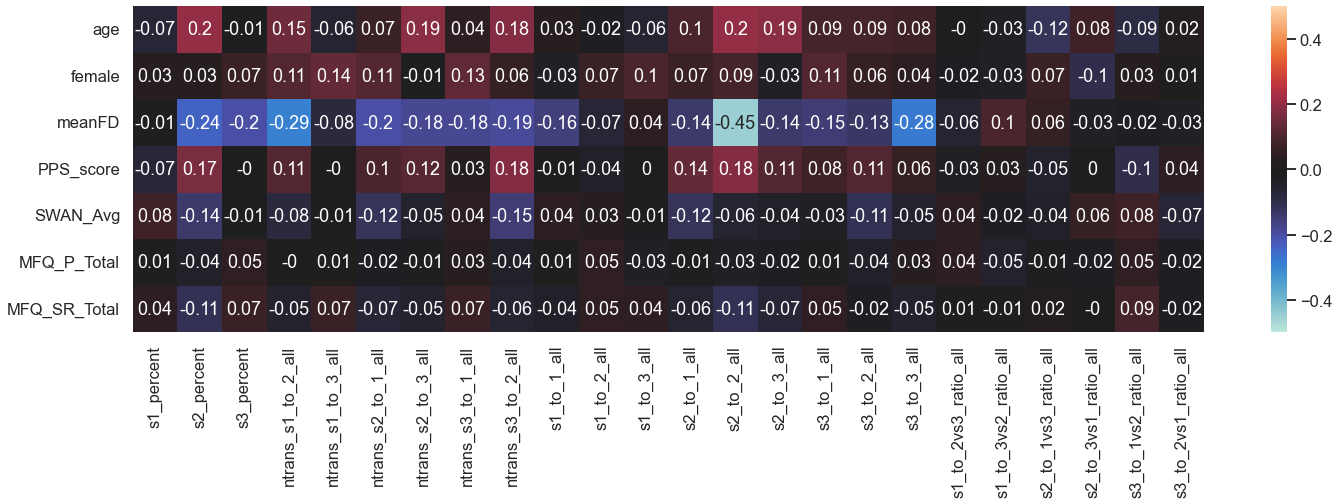

In [11]:
movie='DM'
full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
c = full_data.corr()
plt.figure(figsize=(24,6))
sns.heatmap(c.loc[['age', 'female', 'meanFD','PPS_score', 'SWAN_Avg','MFQ_P_Total','MFQ_SR_Total'],
                  ['s1_percent', 's2_percent', 's3_percent','ntrans_s1_to_2_all', 'ntrans_s1_to_3_all',
                   'ntrans_s2_to_1_all',  'ntrans_s2_to_3_all',
                   'ntrans_s3_to_1_all', 'ntrans_s3_to_2_all', 
                   's1_to_1_all', 's1_to_2_all', 's1_to_3_all', 's2_to_1_all',
                   's2_to_2_all', 's2_to_3_all', 's3_to_1_all', 's3_to_2_all',
                   's3_to_3_all', 's1_to_2vs3_ratio_all', 's1_to_3vs2_ratio_all',
                   's2_to_1vs3_ratio_all', 's2_to_3vs1_ratio_all', 's3_to_1vs2_ratio_all',
                   's3_to_2vs1_ratio_all']].round(2), 
            center=0, vmax=0.5, vmin=-0.5, annot=True)

In [12]:
neg_odds_info_df.columns

Index(['s1_to_1_neg', 'ntrans_s1_to_1_neg', 's1_to_2_neg',
       'ntrans_s1_to_2_neg', 's1_to_3_neg', 'ntrans_s1_to_3_neg',
       's2_to_1_neg', 'ntrans_s2_to_1_neg', 's2_to_2_neg',
       'ntrans_s2_to_2_neg', 's2_to_3_neg', 'ntrans_s2_to_3_neg',
       's3_to_1_neg', 'ntrans_s3_to_1_neg', 's3_to_2_neg',
       'ntrans_s3_to_2_neg', 's3_to_3_neg', 'ntrans_s3_to_3_neg',
       's1_to_2vs3_ratio_neg', 's1_to_3vs2_ratio_neg', 's2_to_1vs3_ratio_neg',
       's2_to_3vs1_ratio_neg', 's3_to_1vs2_ratio_neg', 's3_to_2vs1_ratio_neg'],
      dtype='object')

<AxesSubplot:>

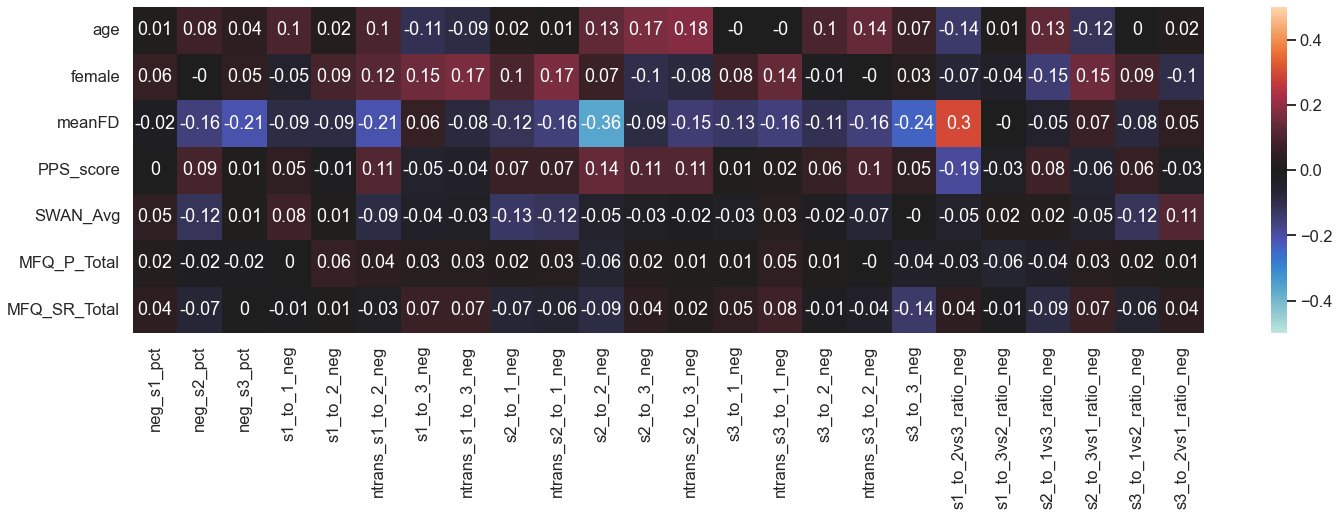

In [13]:
movie='DM'

full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
c = full_data.corr().round(2)
plt.figure(figsize=(24,6))
sns.heatmap(c.loc[['age', 'female', 'meanFD','PPS_score','SWAN_Avg','MFQ_P_Total','MFQ_SR_Total'],
                  ['neg_s1_pct', 'neg_s2_pct', 'neg_s3_pct','s1_to_1_neg',  's1_to_2_neg',
                   'ntrans_s1_to_2_neg', 's1_to_3_neg', 'ntrans_s1_to_3_neg',
                   's2_to_1_neg', 'ntrans_s2_to_1_neg', 's2_to_2_neg','s2_to_3_neg', 'ntrans_s2_to_3_neg',
                   's3_to_1_neg', 'ntrans_s3_to_1_neg', 's3_to_2_neg',
                   'ntrans_s3_to_2_neg', 's3_to_3_neg', 's1_to_2vs3_ratio_neg', 's1_to_3vs2_ratio_neg', 
                   's2_to_1vs3_ratio_neg','s2_to_3vs1_ratio_neg', 's3_to_1vs2_ratio_neg', 's3_to_2vs1_ratio_neg']], 
            center=0, vmax=0.5, vmin=-0.5, annot=True)

## Compare age and puberty associations (full data)

In [142]:
from sklearn.preprocessing import StandardScaler, PowerTransformer

vs = ['age',  'meanFD',  'PPS_score', 's0_percent', 's1_percent', 's2_percent', 's3_percent',  'SWAN_Avg',
      's0_to_1vs2_ratio_all', 's0_to_2vs1_ratio_all','s1_to_0vs2_ratio_all', 's1_to_2vs0_ratio_all', 's2_to_0vs1_ratio_all','s2_to_1vs0_ratio_all']

vois = ['s0_percent', 's1_percent', 's2_percent', 's3_percent', 's0_to_1vs2_ratio_all', 
        's0_to_2vs1_ratio_all','s1_to_0vs2_ratio_all', 's1_to_2vs0_ratio_all', 's2_to_0vs1_ratio_all','s2_to_1vs0_ratio_all']

results_df = pd.DataFrame()
i=0

for movie in ['DM','TP']:
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    
    for s in vois:
        results = smf.glm('{0} ~ age + female + meanFD'.format(s), data=full_data).fit()
        ci=results.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'age_coeff'] = results.params['age']
        results_df.loc[i, 'age_stat'] = results.tvalues['age']
        results_df.loc[i, 'age_pval'] = results.pvalues['age']
        results_df.loc[i, 'age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'female_coeff'] = results.params['female']
        results_df.loc[i, 'female_stat'] = results.tvalues['female']
        results_df.loc[i, 'female_pval'] = results.pvalues['female']
        results_df.loc[i, 'female_ci'] = '[{0}, {1}]'.format(round(ci.loc['female',0],2),round(ci.loc['female',1],2))
        i = i + 1
results_df.to_csv(os.path.join(out_folder, 'movieBoth_full_dataset_age_sex_motion_analysis.csv'))

results_df = pd.DataFrame()
i=0

for movie in ['DM','TP']:
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    
    for s in vois:
        results = smf.glm('{0} ~ PPS_score + female + meanFD'.format(s), data=full_data).fit()
        ci=results.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'PPS_score_coeff'] = results.params['PPS_score']
        results_df.loc[i, 'PPS_score_stat'] = results.tvalues['PPS_score']
        results_df.loc[i, 'PPS_score_pval'] = results.pvalues['PPS_score']
        results_df.loc[i, 'PPS_score_ci'] = '[{0}, {1}]'.format(round(ci.loc['PPS_score',0],2),round(ci.loc['PPS_score',1],2))
        results_df.loc[i, 'female_coeff'] = results.params['female']
        results_df.loc[i, 'female_stat'] = results.tvalues['female']
        results_df.loc[i, 'female_pval'] = results.pvalues['female']
        results_df.loc[i, 'female_ci'] = '[{0}, {1}]'.format(round(ci.loc['female',0],2),round(ci.loc['female',1],2))
        i = i + 1
results_df.to_csv(os.path.join(out_folder, 'movieBoth_full_dataset_puberty_sex_motion_analysis.csv'))

## Compare puberty and age (neg)

In [143]:
vs = ['age',  'meanFD',  'PPS_score', 'neg_s0_pct', 'neg_s1_pct', 'neg_s2_pct',  'neg_s3_pct', 'SWAN_Avg','s0_to_1vs2_ratio_neg',
      's0_to_2vs1_ratio_neg','s1_to_0vs2_ratio_neg', 's1_to_2vs0_ratio_neg', 's2_to_0vs1_ratio_neg','s2_to_1vs0_ratio_neg']
vois = ['s0_to_1vs2_ratio_neg','s0_to_2vs1_ratio_neg','s1_to_0vs2_ratio_neg', 's1_to_2vs0_ratio_neg', 
        's2_to_0vs1_ratio_neg','s2_to_1vs0_ratio_neg']

results_df = pd.DataFrame()
i=0
    
for movie in ['DM','TP']:
    for n in ['neg']:
        full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
        full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())

        for s in vois:
            results = smf.glm('{0} ~ age + female + meanFD'.format(s), data=full_data).fit()
            ci=results.conf_int()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'age_coeff'] = results.params['age']
            results_df.loc[i, 'age_stat'] = results.tvalues['age']
            results_df.loc[i, 'age_pval'] = results.pvalues['age']
            results_df.loc[i, 'age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
            i = i + 1
    results_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_dataset_age_analysis.csv'.format(movie)))

    results_df = pd.DataFrame()
    i=0

    for n in ['neg']:
        full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
        full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())

        for s in vois:
            results = smf.glm('{0} ~ PPS_score + female + meanFD'.format(s), data=full_data).fit()
            ci=results.conf_int()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'PPS_score_coeff'] = results.params['PPS_score']
            results_df.loc[i, 'PPS_score_stat'] = results.tvalues['PPS_score']
            results_df.loc[i, 'PPS_score_pval'] = results.pvalues['PPS_score']
            results_df.loc[i, 'PPS_score_ci'] = '[{0}, {1}]'.format(round(ci.loc['PPS_score',0],2),round(ci.loc['PPS_score',1],2))
            i = i + 1
    results_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_dataset_puberty_analysis.csv'.format(movie)))

## look at state info during negative states

In [144]:
results_df = pd.DataFrame()
i=0
    
for movie in ['DM','TP']:
    for n in ['neg']:
        full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
        full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())

        for s in vois:
            results = smf.glm('{0} ~ age + female + meanFD + SWAN_Avg'.format(s), data=full_data).fit()
            ci=results.conf_int()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'adhd_coeff'] = results.params['SWAN_Avg']
            results_df.loc[i, 'adhd_stat'] = results.tvalues['SWAN_Avg']
            results_df.loc[i, 'adhd_pval'] = results.pvalues['SWAN_Avg']
            results_df.loc[i, 'adhd_ci'] = '[{0}, {1}]'.format(round(ci.loc['SWAN_Avg',0],2),round(ci.loc['SWAN_Avg',1],2))
            results_df.loc[i, 'female_coeff'] = results.params['female']
            results_df.loc[i, 'female_stat'] = results.tvalues['female']
            results_df.loc[i, 'female_pval'] = results.pvalues['female']
            results_df.loc[i, 'female_ci'] = '[{0}, {1}]'.format(round(ci.loc['female',0],2),round(ci.loc['female',1],2))
            i = i + 1
    results_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_dataset_adhd_sex_analysis.csv'.format(movie)))

# Anxiety

## Characterize overall associations

<Axes: >

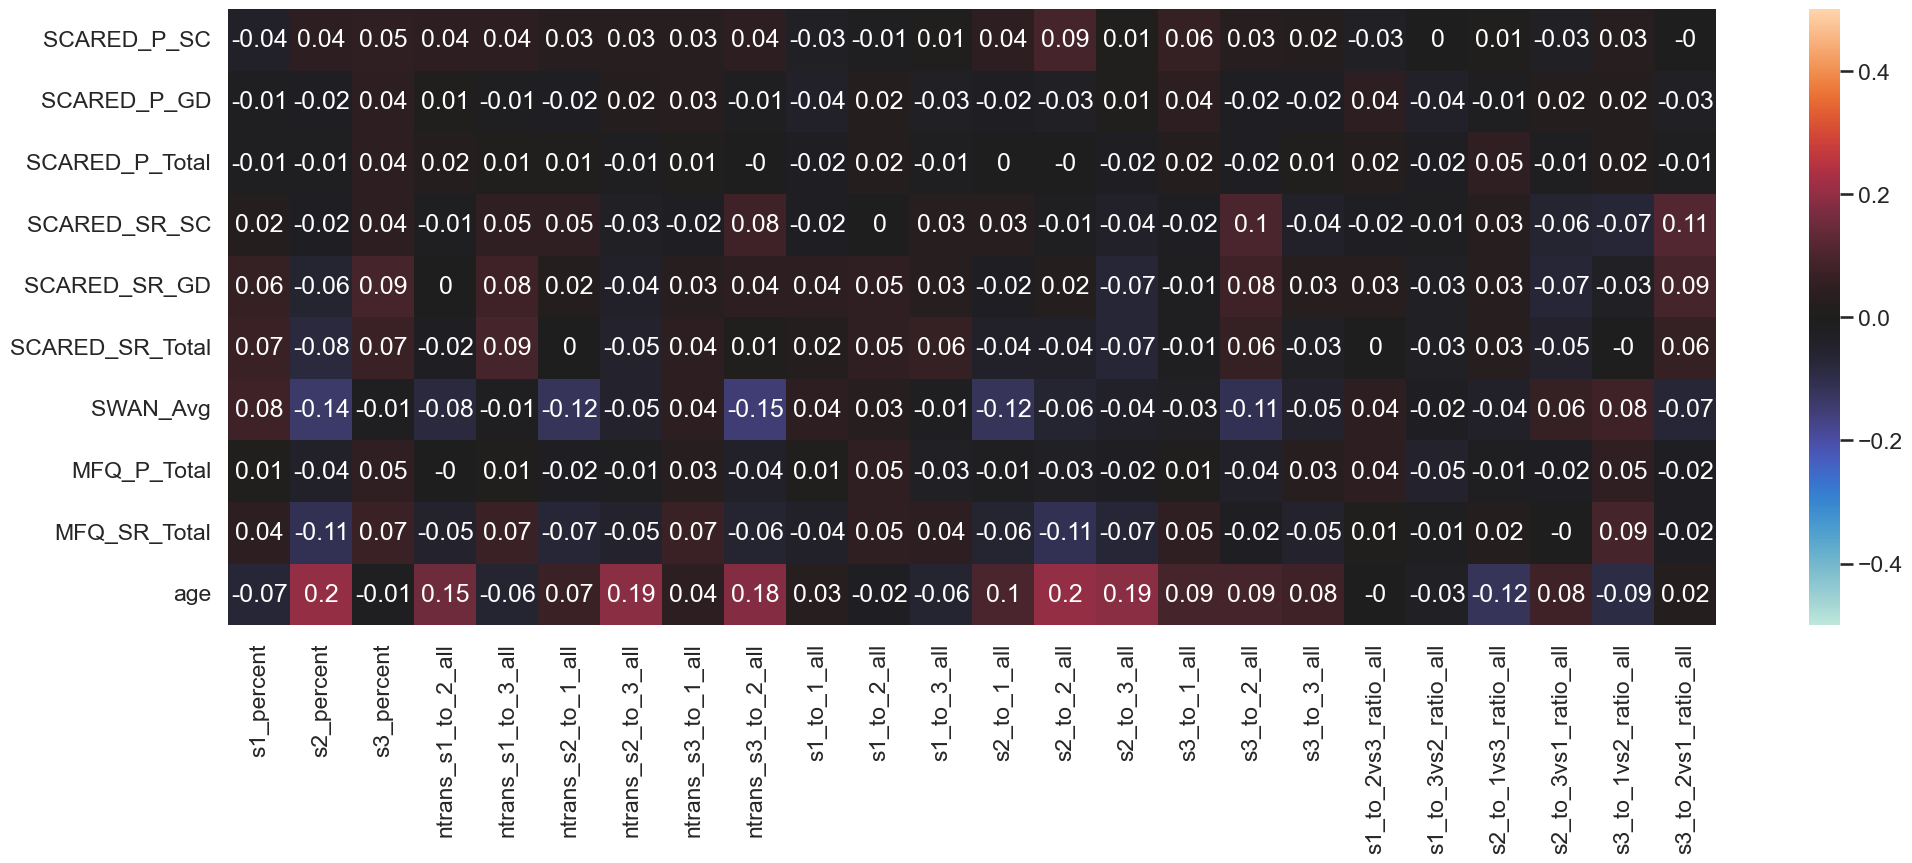

In [7]:
vois = ['s1_percent', 's2_percent', 's3_percent','ntrans_s1_to_2_all', 'ntrans_s1_to_3_all',
                   'ntrans_s2_to_1_all',  'ntrans_s2_to_3_all',
                   'ntrans_s3_to_1_all', 'ntrans_s3_to_2_all', 
                   's1_to_1_all', 's1_to_2_all', 's1_to_3_all', 's2_to_1_all',
                   's2_to_2_all', 's2_to_3_all', 's3_to_1_all', 's3_to_2_all',
                   's3_to_3_all', 's1_to_2vs3_ratio_all', 's1_to_3vs2_ratio_all',
                   's2_to_1vs3_ratio_all', 's2_to_3vs1_ratio_all', 's3_to_1vs2_ratio_all',
                   's3_to_2vs1_ratio_all']
sxs = ['SCARED_P_SC', 'SCARED_P_GD', 'SCARED_P_Total',
                       'SCARED_SR_SC', 'SCARED_SR_GD', 'SCARED_SR_Total', 
                       'SWAN_Avg', 'MFQ_P_Total','MFQ_SR_Total','age']


full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
c = full_data.loc[:,sxs+vois].corr().round(2)
plt.figure(figsize=(24,8))
sns.heatmap(c.loc[sxs, vois],center=0, vmax=0.5, vmin=-0.5, annot=True)

<Axes: >

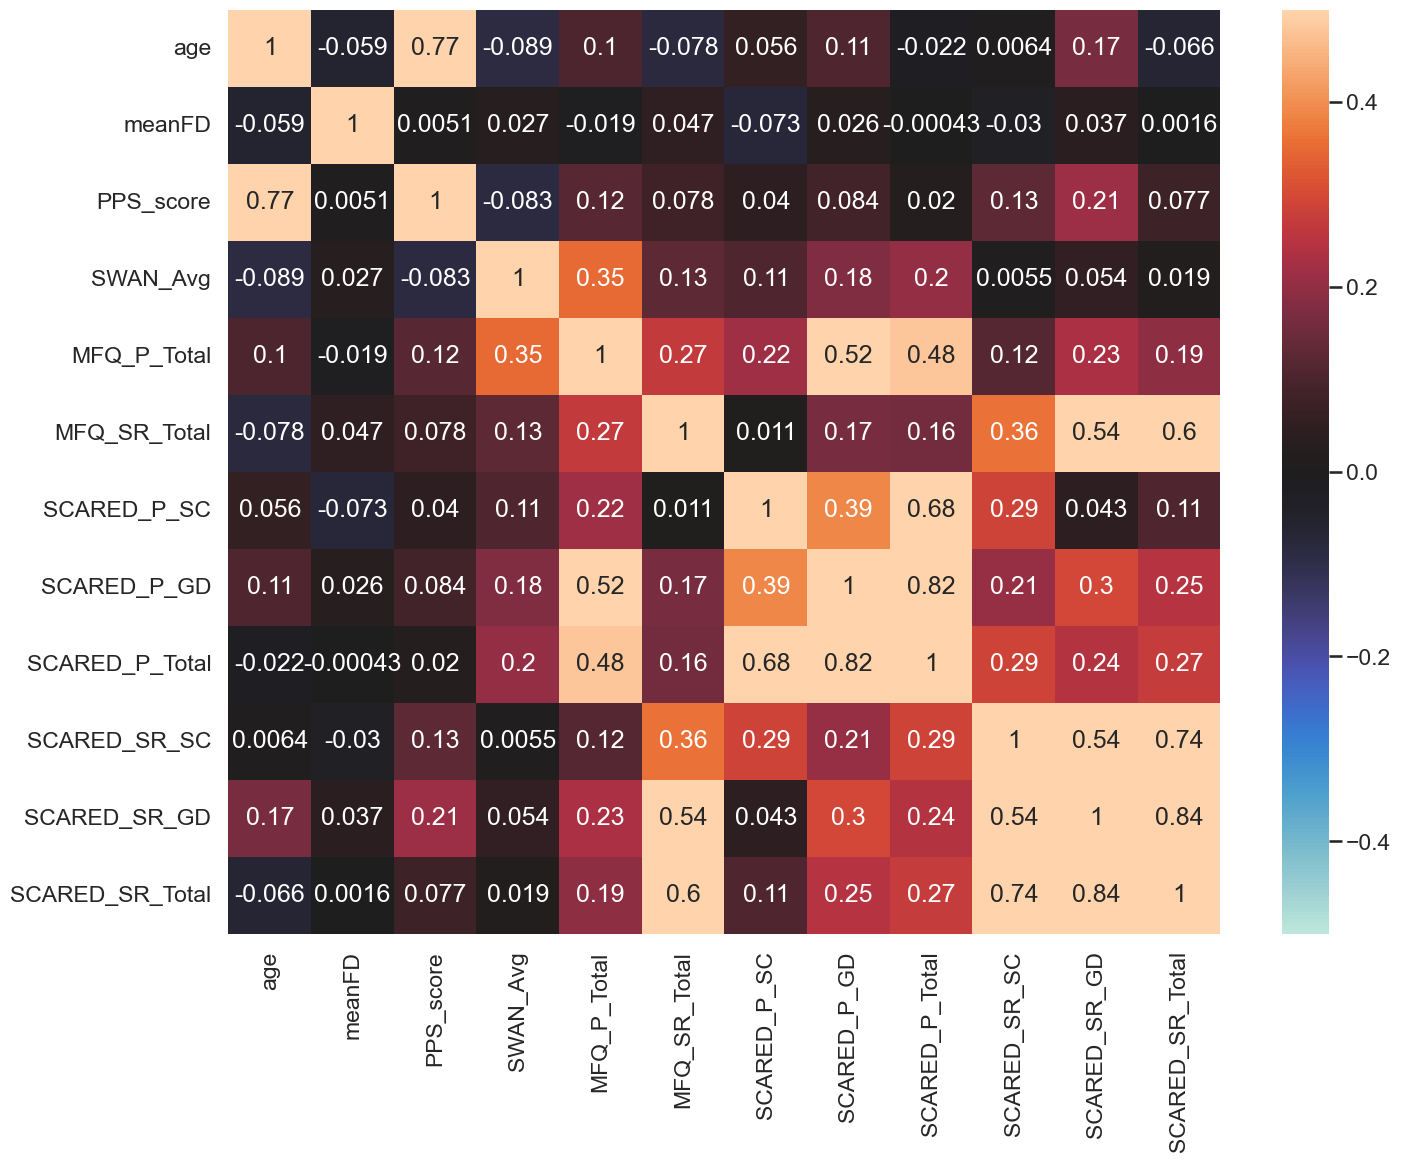

In [10]:
full_data = pd.read_csv(os.path.join(out_folder, 'movieDM_full_dataset.csv'), index_col=0)
full_data = full_data.drop(['movie','site'],axis=1)
c = full_data.corr(method='spearman')
plt.figure(figsize=(16,12))
sns.heatmap(c.loc[['age', 'meanFD','PPS_score', 'SWAN_Avg','MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_P_GD', 'SCARED_P_Total',
                       'SCARED_SR_SC', 'SCARED_SR_GD', 'SCARED_SR_Total',],
                  ['age', 'meanFD','PPS_score', 'SWAN_Avg','MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_P_GD', 'SCARED_P_Total',
                       'SCARED_SR_SC', 'SCARED_SR_GD', 'SCARED_SR_Total',]], 
            center=0, vmax=0.5, vmin=-0.5, annot=True)

In [148]:
full_data = pd.read_csv(os.path.join(out_folder, 'movieDM_full_dataset.csv'), index_col=0)
full_data.loc[:,['age','SCARED_P_SC', 'SCARED_P_GD', 'SCARED_P_Total',
                       'SCARED_SR_SC', 'SCARED_SR_GD', 'SCARED_SR_Total', 'SWAN_Avg','MFQ_P_Total','MFQ_SR_Total']].describe()

,age,SCARED_P_SC,SCARED_P_GD,SCARED_P_Total,SCARED_SR_SC,SCARED_SR_GD,SCARED_SR_Total,SWAN_Avg,MFQ_P_Total,MFQ_SR_Total
count,432.000000,424.000000,424.000000,424.000000,432.000000,432.000000,432.000000,423.000000,426.000000,432.000000
mean,11.485975,4.351415,4.801887,14.235849,5.164352,5.231481,21.956019,0.311925,9.483568,12.780093
std,2.234824,3.723492,3.949851,10.600684,3.958993,4.443732,15.858434,0.989494,8.764150,11.281477
min,7.721879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.611111,0.000000,0.000000
25%,9.588038,1.000000,2.000000,6.000000,2.000000,1.000000,9.750000,-0.138888,3.000000,5.000000
50%,11.236196,4.000000,4.000000,12.000000,5.000000,5.000000,19.000000,0.388888,7.000000,10.000000
75%,13.436259,7.000000,7.000000,20.000000,8.000000,8.000000,30.000000,0.944444,14.000000,17.000000
max,15.974332,14.000000,18.000000,52.000000,14.000000,18.000000,73.000000,2.888888,54.000000,61.000000


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

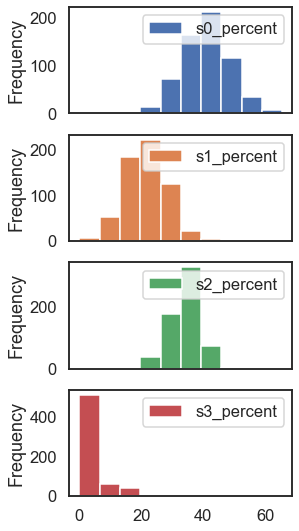

In [49]:
full_data.loc[:,['s0_percent', 's1_percent', 's2_percent', 's3_percent']].plot(subplots=True, kind='hist', figsize=(4,9))

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

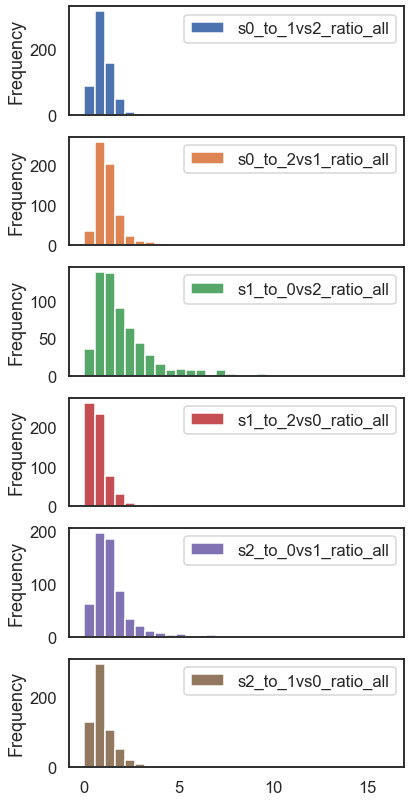

In [51]:
full_data.loc[:,['s0_to_1vs2_ratio_all', 's0_to_2vs1_ratio_all','s1_to_0vs2_ratio_all', 
                 's1_to_2vs0_ratio_all', 's2_to_0vs1_ratio_all','s2_to_1vs0_ratio_all']].plot(subplots=True, kind='hist', bins=30, figsize=(6,14))

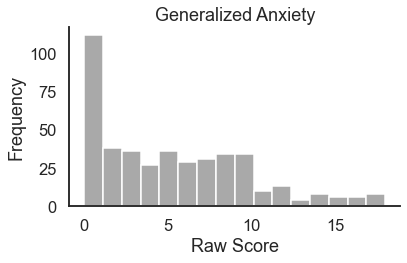

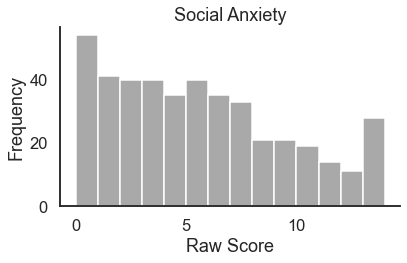

In [2]:
movie='DM'
full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
full_data.loc[:,'SCARED_SR_GD'].plot(kind='hist', bins=16, color='darkgray')
plt.title('Generalized Anxiety')
plt.xlabel('Raw Score')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'group-movie{0}_SCARED-SR_GA_hist.png'.format(movie)), dpi=300)
plt.show()
plt.close()

full_data.loc[:,'SCARED_SR_SC'].plot(kind='hist', bins=14, color='darkgray')
plt.title('Social Anxiety')
plt.xlabel('Raw Score')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'group-movie{0}_SCARED-SR_SA_hist.png'.format(movie)), dpi=300)
plt.show()
plt.close()

In [17]:
pct = ['s1_percent', 's2_percent', 's3_percent']
trans = ['ntrans_s1_to_2_all', 'ntrans_s1_to_3_all','ntrans_s2_to_1_all',  
         'ntrans_s2_to_3_all','ntrans_s3_to_1_all', 'ntrans_s3_to_2_all']
odds = ['s1_to_1_all', 's1_to_2_all', 's1_to_3_all', 's2_to_1_all',
        's2_to_2_all', 's2_to_3_all', 's3_to_1_all', 's3_to_2_all',
        's3_to_3_all']
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg'] + pct + trans + odds
cs = ['SCARED_SR_GD', 'SCARED_SR_SC', 'SCARED_SR_Total', 'MFQ_SR_Total']
movie='DM'

results_df = pd.DataFrame()

i=0
for c in ['SCARED_SR_GD', 'SCARED_SR_SC']:
    start = i
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())
    
    for s in pct:
        results = smf.glm('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        results_df.loc[i, 'IV_coeff'] = results.params[c]
        results_df.loc[i, 'IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'IV_pval'] = results.pvalues[c]
        ci=results.conf_int()
        results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'FDRp'] = np.nan
        i = i + 1
    rej, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p
    
    start = i
    for s in trans:
        results = smf.glm('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        results_df.loc[i, 'IV_coeff'] = results.params[c]
        results_df.loc[i, 'IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'IV_pval'] = results.pvalues[c]
        ci=results.conf_int()
        results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'FDRp'] = np.nan
        i = i + 1
    _, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p

    start = i
    for s in odds:
        results = smf.glm('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        results_df.loc[i, 'IV_coeff'] = results.params[c]
        results_df.loc[i, 'IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'IV_pval'] = results.pvalues[c]
        ci=results.conf_int()
        results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'FDRp'] = np.nan
        i = i + 1
    _, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p
results_df.to_csv(os.path.join(out_folder, 'movieBoth_full_GD_analysis_results.csv'))
results_df

,movie,DV,IV,IV_coeff,IV_stat,IV_pval,IV_ci,FDRp
0,DM,s1_percent,SCARED_SR_GD,0.047824,0.977056,0.328542,"[-0.05, 0.14]",0.328542
1,DM,s2_percent,SCARED_SR_GD,-0.093608,-2.012204,0.044198,"[-0.18, -0.0]",0.066298
2,DM,s3_percent,SCARED_SR_GD,0.124349,2.627101,0.008612,"[0.03, 0.22]",0.025835
3,DM,ntrans_s1_to_2_all,SCARED_SR_GD,-0.027911,-0.596718,0.550695,"[-0.12, 0.06]",0.781008
4,DM,ntrans_s1_to_3_all,SCARED_SR_GD,0.056268,1.188751,0.234538,"[-0.04, 0.15]",0.781008
5,DM,ntrans_s2_to_1_all,SCARED_SR_GD,-0.024180,-0.490531,0.623758,"[-0.12, 0.07]",0.781008
6,DM,ntrans_s2_to_3_all,SCARED_SR_GD,-0.053316,-1.096869,0.272699,"[-0.15, 0.04]",0.781008
7,DM,ntrans_s3_to_1_all,SCARED_SR_GD,0.021667,0.452596,0.650840,"[-0.07, 0.12]",0.781008
8,DM,ntrans_s3_to_2_all,SCARED_SR_GD,-0.013058,-0.268362,0.788421,"[-0.11, 0.08]",0.788421
9,DM,s1_to_1_all,SCARED_SR_GD,0.026992,0.545456,0.585440,"[-0.07, 0.12]",0.906667


In [19]:
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg', 
      's1_percent', 's2_percent', 's3_percent']
cs = ['SCARED_P_GD', 'SCARED_P_Total','SCARED_SR_GD', 'SCARED_SR_Total', 'MFQ_SR_Total']

results_df = pd.DataFrame()

i=0
for c in ['SCARED_SR_GD', 'SCARED_SR_SC']:
    start = i
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())
    
    for s in pct:
        results = smf.glm('{0} ~ {1} + age + female + meanFD + SWAN_Avg'.format(s, c), data=full_data).fit()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        results_df.loc[i, 'IV_coeff'] = results.params[c]
        results_df.loc[i, 'IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'IV_pval'] = results.pvalues[c]
        ci=results.conf_int()
        results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'FDRp'] = np.nan
        i = i + 1
    rej, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p
results_df.to_csv(os.path.join(out_folder, 'movieBoth_full_GD_analysis_results_covarADHD.csv'))
results_df

,movie,DV,IV,IV_coeff,IV_stat,IV_pval,IV_ci,FDRp
0,DM,s1_percent,SCARED_SR_GD,0.043867,0.885160,0.376071,"[-0.05, 0.14]",0.376071
1,DM,s2_percent,SCARED_SR_GD,-0.084906,-1.812625,0.069890,"[-0.18, 0.01]",0.104835
2,DM,s3_percent,SCARED_SR_GD,0.125039,2.585342,0.009728,"[0.03, 0.22]",0.029185
3,DM,s1_percent,SCARED_SR_SC,0.003649,0.297829,0.765834,"[-0.02, 0.03]",0.765834
4,DM,s2_percent,SCARED_SR_SC,-0.006425,-0.553321,0.580044,"[-0.03, 0.02]",0.765834
5,DM,s3_percent,SCARED_SR_SC,0.007483,0.621706,0.534135,"[-0.02, 0.03]",0.765834


In [20]:
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg', 
      's1_percent', 's2_percent', 's3_percent']
cs = ['SCARED_P_GD', 'SCARED_P_Total','SCARED_SR_GD', 'SCARED_SR_Total', 'MFQ_SR_Total']

results_df = pd.DataFrame()

i=0
for c in ['SCARED_SR_GD', 'SCARED_SR_SC']:
    start = i
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())
    
    for s in pct:
        results = smf.glm('{0} ~ {1} + age + female + meanFD + MFQ_SR_Total'.format(s, c), data=full_data).fit()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        results_df.loc[i, 'IV_coeff'] = results.params[c]
        results_df.loc[i, 'IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'IV_pval'] = results.pvalues[c]
        ci=results.conf_int()
        results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'FDRp'] = np.nan
        i = i + 1
    rej, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p
results_df.to_csv(os.path.join(out_folder, 'movieBoth_full_GD_analysis_results_covarMDD.csv'))
results_df

,movie,DV,IV,IV_coeff,IV_stat,IV_pval,IV_ci,FDRp
0,DM,s1_percent,SCARED_SR_GD,0.029348,0.489164,0.624726,"[-0.09, 0.15]",0.728610
1,DM,s2_percent,SCARED_SR_GD,-0.019674,-0.346976,0.728610,"[-0.13, 0.09]",0.728610
2,DM,s3_percent,SCARED_SR_GD,0.093153,1.606663,0.108128,"[-0.02, 0.21]",0.324385
3,DM,s1_percent,SCARED_SR_SC,-0.001156,-0.086888,0.930760,"[-0.03, 0.02]",0.930760
4,DM,s2_percent,SCARED_SR_SC,0.008665,0.689640,0.490420,"[-0.02, 0.03]",0.930760
5,DM,s3_percent,SCARED_SR_SC,-0.005656,-0.438809,0.660800,"[-0.03, 0.02]",0.930760


In [22]:
# Make density plots for low and high anxiety children
movie='DM'
# pull in data
full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
group_state_data = np.load(os.path.join(out_folder,'group-movie{0}_k3_states.npy'.format(movie)))
sample_res_df = pd.DataFrame(np.squeeze(group_state_data), columns=timing)
dfs = []

# upper 20%
mask = (full_data['SCARED_SR_GD'] >= np.percentile(full_data.loc[np.isfinite(full_data['SCARED_SR_GD']),'SCARED_SR_GD'],70)).to_numpy()
lim_df = sample_res_df.loc[mask==True,:]
states_counts_df = pd.DataFrame()
for i in lim_df.columns:
    states_counts_df.loc[i,'s1'] = sum(lim_df[i]==1)
    states_counts_df.loc[i,'s2'] = sum(lim_df[i]==2)
    states_counts_df.loc[i,'s3'] = sum(lim_df[i]==3)

data_perc = states_counts_df.divide(states_counts_df.sum(axis=1), axis=0)
data_perc['group']='highGD'
dfs.append(data_perc)


# lower 20%
mask = (full_data['SCARED_SR_GD'] <= np.percentile(full_data.loc[np.isfinite(full_data['SCARED_SR_GD']),'SCARED_SR_GD'],30)).to_numpy()
lim_df = sample_res_df.loc[mask,:]
states_counts_df = pd.DataFrame()
for i in lim_df.columns:
    states_counts_df.loc[i,'s1'] = sum(lim_df[i]==1)
    states_counts_df.loc[i,'s2'] = sum(lim_df[i]==2)
    states_counts_df.loc[i,'s3'] = sum(lim_df[i]==3)

data_perc = states_counts_df.divide(states_counts_df.sum(axis=1), axis=0)
data_perc['group']='lowGD'
dfs.append(data_perc)


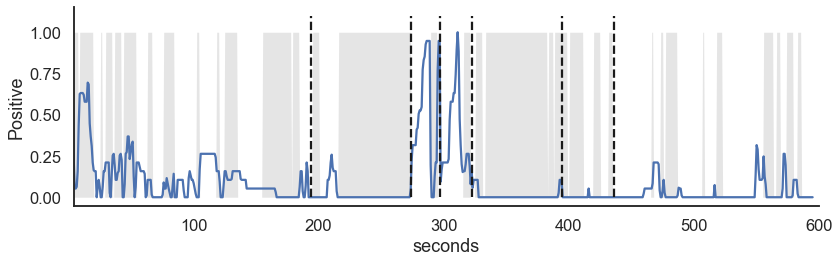

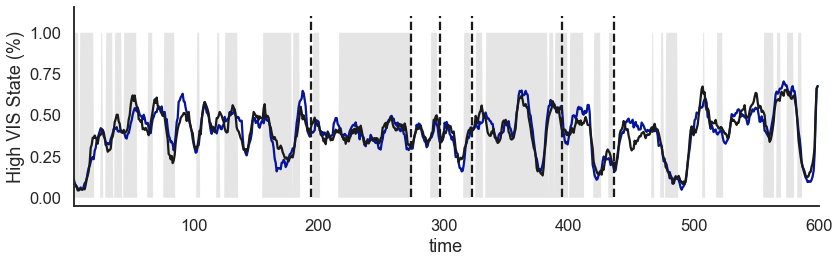

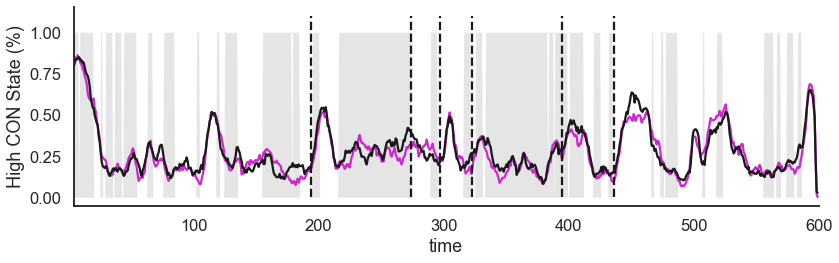

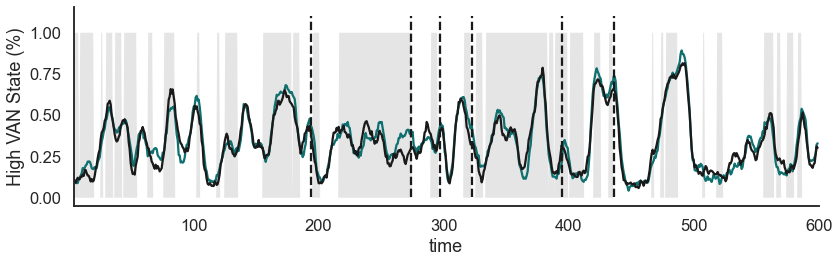

In [24]:
# combine 
clip_dfs = [a.iloc[5:,:] for a in dfs]
groups_perc = pd.concat(clip_dfs)
groups_perc['time'] = groups_perc.index
groups_perc.index = range(len(groups_perc.index))

features = pd.read_csv(os.path.join(hbn_folder, 'HBN_video_coding','processing','v1','summary',
                                    '{0}_summary_codes_intuitivenames.csv'.format(movie)), index_col=0)
features = features.iloc[:-5,:]
scene_timing = pd.read_csv(os.path.join(hbn_folder, 'HBN_video_coding','Videos','DM_scenes.csv'), index_col=0)
features['High_Negative'] = 0
features.loc[features['Negative']>=1,'High_Negative']=1
features.loc[:,:] = MinMaxScaler().fit_transform(features.to_numpy())


# plot
plt.figure(figsize=(12,4))
sns.lineplot(x=features.index, y='Positive', data=features)
plt.fill_between(features.index, features['High_Negative'], color='gray', alpha=0.2, lw=0)
plt.vlines(scene_timing['start'], 0, 1.1, color='k', linestyles='--')
plt.xlim(4,600)
sns.despine()
plt.tight_layout()
plt.show()
plt.close()


# plot
plt.figure(figsize=(12,4))
sns.lineplot(x='time', y='s1', data=groups_perc, hue='group', palette=[state_palette[0],'k'], legend=False)
plt.fill_between(features.index, features['High_Negative'], color='gray', alpha=0.2, lw=0)
plt.vlines(scene_timing['start'], 0, 1.1, color='k', linestyles='--')
plt.xlim(4,600)
plt.ylabel('High VIS State (%)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_k4_density_byGD_state0.png'), dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(12,4))
sns.lineplot(x='time', y='s2', data=groups_perc, hue='group', palette=[state_palette[1],'k'], legend=False)
plt.fill_between(features.index, features['High_Negative'], color='gray', alpha=0.2, lw=0)
plt.vlines(scene_timing['start'], 0, 1.1, color='k', linestyles='--')
plt.xlim(4,600)
plt.ylabel('High CON State (%)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_k4_density_byGD_state1.png'), dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(12,4))
sns.lineplot(x='time', y='s3', data=groups_perc, hue='group', palette=[state_palette[2],'k'], legend=False)
plt.fill_between(features.index, features['High_Negative'], color='gray', alpha=0.2, lw=0)
plt.vlines(scene_timing['start'], 0, 1.1, color='k', linestyles='--')
plt.xlim(4,600)
plt.ylabel('High VAN State (%)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_k4_density_byGD_state2.png'), dpi=300)
plt.show()
plt.close()

In [76]:
full_data['SCARED_SR_GD'].describe()

count    432.000000
mean       5.231481
std        4.443732
min        0.000000
25%        1.000000
50%        5.000000
75%        8.000000
max       18.000000
Name: SCARED_SR_GD, dtype: float64

## look at state info during negative emotion processing

In [26]:
movie='DM'
full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
full_data.columns[-70:]

Index(['s3_Auditory', 's3_CinguloOperc', 's3_Default', 's3_DorsalAttn',
       's3_FrontoParietal', 's3_SMhand', 's3_SMmouth', 's3_Salience',
       's3_VentralAttn', 's3_Visual', 'ntrans_s1_to_1_all',
       'ntrans_s1_to_2_all', 'ntrans_s1_to_3_all', 'ntrans_s2_to_1_all',
       'ntrans_s2_to_2_all', 'ntrans_s2_to_3_all', 'ntrans_s3_to_1_all',
       'ntrans_s3_to_2_all', 'ntrans_s3_to_3_all', 's1_to_1_all',
       's1_to_2_all', 's1_to_3_all', 's2_to_1_all', 's2_to_2_all',
       's2_to_3_all', 's3_to_1_all', 's3_to_2_all', 's3_to_3_all',
       's1_to_2vs3_ratio_all', 's1_to_3vs2_ratio_all', 's2_to_1vs3_ratio_all',
       's2_to_3vs1_ratio_all', 's3_to_1vs2_ratio_all', 's3_to_2vs1_ratio_all',
       'neg_s1_pct', 'nonneg_s1_pct', 'neg_s1_prob', 'nonneg_s1_prob',
       'neg_s2_pct', 'nonneg_s2_pct', 'neg_s2_prob', 'nonneg_s2_prob',
       'neg_s3_pct', 'nonneg_s3_pct', 'neg_s3_prob', 'nonneg_s3_prob',
       's1_to_1_neg', 'ntrans_s1_to_1_neg', 's1_to_2_neg',
       'ntrans_s1_to_2

In [28]:
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg', 'neg_s1_pct',
       'nonneg_s1_pct', 'neg_s1_prob', 'nonneg_s1_prob', 'neg_s2_pct',
       'nonneg_s2_pct', 'neg_s2_prob', 'nonneg_s2_prob', 'neg_s3_pct',
       'nonneg_s3_pct', 'neg_s3_prob', 'nonneg_s3_prob']

cs = ['SCARED_P_SC', 'SCARED_P_GD', 'SCARED_P_Total',
       'SCARED_SR_SC', 'SCARED_SR_GD', 'SCARED_SR_Total']

vois_neg_pct = ['neg_s1_pct','neg_s2_pct', 'neg_s3_pct']

vois_nonneg_pct = ['nonneg_s1_pct', 'nonneg_s2_pct', 'nonneg_s3_pct']

vois_txodds = ['s1_to_1_neg', 's1_to_2_neg', 's1_to_3_neg',
               's2_to_1_neg', 's2_to_2_neg', 's2_to_3_neg', 
               's3_to_1_neg', 's3_to_2_neg', 's3_to_3_neg']

vois_trans = ['ntrans_s1_to_2_neg','ntrans_s1_to_3_neg','ntrans_s2_to_1_neg',
              'ntrans_s2_to_3_neg','ntrans_s3_to_1_neg','ntrans_s3_to_2_neg']


movie='DM'
results_df = pd.DataFrame()
i=0

full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())

# time spent in each state
for s in vois_neg_pct:
    results = smf.glm('{0} ~ SCARED_SR_GD + age + female + meanFD'.format(s), 
                      data=full_data).fit()
    ci=results.conf_int()
    results_df.loc[i, 'movie'] = movie
    results_df.loc[i, 'DV'] = s
    results_df.loc[i, 'GD_coeff'] = results.params['SCARED_SR_GD']
    results_df.loc[i, 'GD_stat'] = results.tvalues['SCARED_SR_GD']
    results_df.loc[i, 'GD_pval'] = results.pvalues['SCARED_SR_GD']
    results_df.loc[i, 'GD_ci'] = '[{0}, {1}]'.format(round(ci.loc['SCARED_SR_GD',0],2),round(ci.loc['SCARED_SR_GD',1],2))
    i = i + 1

from statsmodels.stats.multitest import fdrcorrection
rej, fdr_p = fdrcorrection(results_df['GD_pval'])
results_df.loc[:, 'GD_FDRp'] = fdr_p

## transition probabilities
start = i
for s in vois_nonneg_pct:
    results = smf.glm('{0} ~ SCARED_SR_GD + age + female + meanFD'.format(s), 
                      data=full_data).fit()
    ci=results.conf_int()
    results_df.loc[i, 'movie'] = movie
    results_df.loc[i, 'DV'] = s
    results_df.loc[i, 'GD_coeff'] = results.params['SCARED_SR_GD']
    results_df.loc[i, 'GD_stat'] = results.tvalues['SCARED_SR_GD']
    results_df.loc[i, 'GD_pval'] = results.pvalues['SCARED_SR_GD']
    results_df.loc[i, 'GD_ci'] = '[{0}, {1}]'.format(round(ci.loc['SCARED_SR_GD',0],2),round(ci.loc['SCARED_SR_GD',1],2))
    i = i + 1

# fdr correction
from statsmodels.stats.multitest import fdrcorrection
rej, fdr_p = fdrcorrection(results_df['GD_pval'][start:i])
results_df.loc[start:i, 'GD_FDRp'] = fdr_p

## transition counts
start = i
for s in vois_txodds:
    results = smf.glm('{0} ~ SCARED_SR_GD + age + female + meanFD'.format(s), 
                      data=full_data).fit()
    ci=results.conf_int()
    results_df.loc[i, 'movie'] = movie
    results_df.loc[i, 'DV'] = s
    results_df.loc[i, 'GD_coeff'] = results.params['SCARED_SR_GD']
    results_df.loc[i, 'GD_stat'] = results.tvalues['SCARED_SR_GD']
    results_df.loc[i, 'GD_pval'] = results.pvalues['SCARED_SR_GD']
    results_df.loc[i, 'GD_ci'] = '[{0}, {1}]'.format(round(ci.loc['SCARED_SR_GD',0],2),round(ci.loc['SCARED_SR_GD',1],2))
    i = i + 1

# fdr correction
from statsmodels.stats.multitest import fdrcorrection
rej, fdr_p = fdrcorrection(results_df['GD_pval'][start:i])
results_df.loc[start:, 'GD_FDRp'] = fdr_p

## transition odds
start = i
for s in vois_trans:
    results = smf.glm('{0} ~ SCARED_SR_GD + age + female + meanFD'.format(s), 
                      data=full_data).fit()
    ci=results.conf_int()
    results_df.loc[i, 'movie'] = movie
    results_df.loc[i, 'DV'] = s
    results_df.loc[i, 'GD_coeff'] = results.params['SCARED_SR_GD']
    results_df.loc[i, 'GD_stat'] = results.tvalues['SCARED_SR_GD']
    results_df.loc[i, 'GD_pval'] = results.pvalues['SCARED_SR_GD']
    results_df.loc[i, 'GD_ci'] = '[{0}, {1}]'.format(round(ci.loc['SCARED_SR_GD',0],2),round(ci.loc['SCARED_SR_GD',1],2))
    i = i + 1

# fdr correction
from statsmodels.stats.multitest import fdrcorrection
rej, fdr_p = fdrcorrection(results_df['GD_pval'][start:i])
results_df.loc[start:, 'GD_FDRp'] = fdr_p

results_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_GD_sanalysis_results.csv'.format(movie)))
results_df

,movie,DV,GD_coeff,GD_stat,GD_pval,GD_ci,GD_FDRp
0,DM,neg_s1_pct,0.073460,1.499451,0.133757,"[-0.02, 0.17]",0.133757
1,DM,neg_s2_pct,-0.113270,-2.369380,0.017818,"[-0.21, -0.02]",0.047541
2,DM,neg_s3_pct,0.104108,2.148248,0.031694,"[0.01, 0.2]",0.047541
3,DM,nonneg_s1_pct,0.016059,0.327279,0.743457,"[-0.08, 0.11]",0.743457
4,DM,nonneg_s2_pct,-0.053623,-1.137969,0.255134,"[-0.15, 0.04]",0.382700
5,DM,nonneg_s3_pct,0.074111,1.478049,0.139395,"[-0.02, 0.17]",0.382700
6,DM,s1_to_1_neg,-0.000243,-0.146341,0.883652,"[-0.0, 0.0]",0.905140
7,DM,s1_to_2_neg,0.001664,1.174113,0.240350,"[-0.0, 0.0]",0.406398
8,DM,s1_to_3_neg,0.001843,1.966634,0.049225,"[0.0, 0.0]",0.221514
9,DM,s2_to_1_neg,-0.001138,-1.100918,0.270932,"[-0.0, 0.0]",0.406398


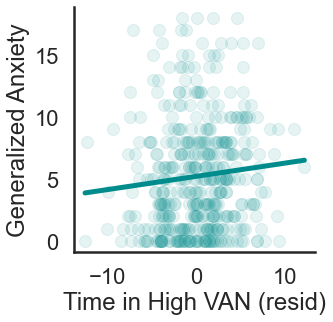

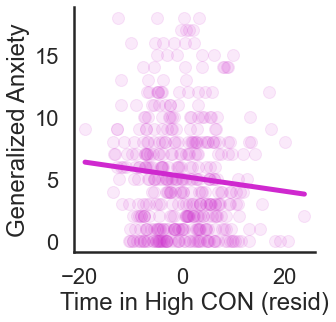

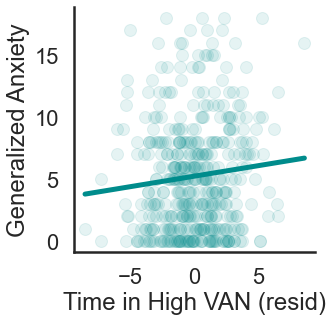

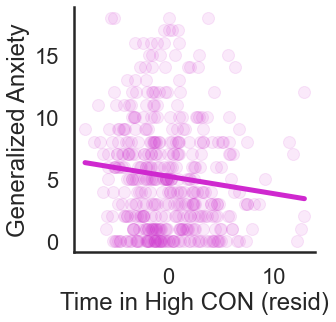

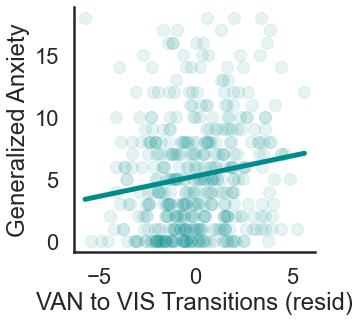

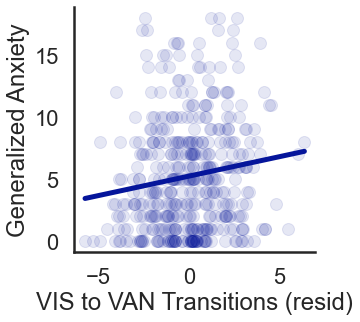

In [31]:
sns.set(context='poster', style='white')
# residualized brain state measures and plot
full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
res = smf.glm('s3_percent ~ age + female + meanFD', data=full_data).fit()
t = pd.DataFrame(res.resid_response, index = res.resid_response.index, columns = ['resid_s3_pct'])
full_data = full_data.merge(t, how='left', left_index=True, right_index=True) 
res = smf.glm('s2_percent ~ age + female + meanFD', data=full_data).fit()
t = pd.DataFrame(res.resid_response, index = res.resid_response.index, columns = ['resid_s2_pct'])
full_data = full_data.merge(t, how='left', left_index=True, right_index=True) 
res = smf.glm('neg_s3_pct ~ age + female + meanFD', data=full_data).fit()
t = pd.DataFrame(res.resid_response, index = res.resid_response.index, columns = ['resid_neg_s3_pct'])
full_data = full_data.merge(t, how='left', left_index=True, right_index=True) 
res = smf.glm('neg_s2_pct ~ age + female + meanFD', data=full_data).fit()
t = pd.DataFrame(res.resid_response, index = res.resid_response.index, columns = ['resid_neg_s2_pct'])
full_data = full_data.merge(t, how='left', left_index=True, right_index=True) 
res = smf.glm('ntrans_s1_to_3_neg ~ age + female + meanFD', data=full_data).fit()
t = pd.DataFrame(res.resid_response, index = res.resid_response.index, columns = ['resid_ntrans_s1_to_3_neg'])
full_data = full_data.merge(t, how='left', left_index=True, right_index=True) 
res = smf.glm('ntrans_s3_to_1_neg ~ age + female + meanFD', data=full_data).fit()
t = pd.DataFrame(res.resid_response, index = res.resid_response.index, columns = ['resid_ntrans_s3_to_1_neg'])
full_data = full_data.merge(t, how='left', left_index=True, right_index=True) 

sns.lmplot(x='resid_s3_pct', y='SCARED_SR_GD', data=full_data, ci=None, 
           line_kws={'lw':5, 'color':state_palette[2]},
           scatter_kws={'alpha':0.1, 'color':state_palette[2]})
plt.ylabel('Generalized Anxiety')
plt.xlabel('Time in High VAN (resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_GDbyDensity_s3.png'), dpi=300)
plt.show()
plt.close()
sns.lmplot(x='resid_s2_pct', y='SCARED_SR_GD', data=full_data, ci=None, 
           line_kws={'lw':5,'color':state_palette[1]}, 
           scatter_kws={'alpha':0.1,'color':state_palette[1]})
plt.ylabel('Generalized Anxiety')
plt.xlabel('Time in High CON (resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_GDbyDensity_s2.png'), dpi=300)
plt.show()
plt.close()

sns.lmplot(x='resid_neg_s3_pct', y='SCARED_SR_GD', data=full_data, ci=None, 
           line_kws={'lw':5, 'color':state_palette[2]},
           scatter_kws={'alpha':0.1, 'color':state_palette[2]})
plt.ylabel('Generalized Anxiety')
plt.xlabel('Time in High VAN (resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_neg_GDbyDensity_s3.png'), dpi=300)
plt.show()
plt.close()
sns.lmplot(x='resid_neg_s2_pct', y='SCARED_SR_GD', data=full_data, ci=None, 
           line_kws={'lw':5,'color':state_palette[1]}, 
           scatter_kws={'alpha':0.1,'color':state_palette[1]})
plt.ylabel('Generalized Anxiety')
plt.xlabel('Time in High CON (resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_neg_GDbyDensity_s2.png'), dpi=300)
plt.show()
plt.close()


sns.lmplot(x='resid_ntrans_s3_to_1_neg', y='SCARED_SR_GD', data=full_data, ci=None, 
           line_kws={'lw':5,'color':state_palette[2]}, 
           scatter_kws={'alpha':0.1,'color':state_palette[2]})
plt.ylabel('Generalized Anxiety')
plt.xlabel('VAN to VIS Transitions (resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_neg_GDbyTrans_s3s1.png'), dpi=300)
plt.show()
plt.close()

sns.lmplot(x='resid_ntrans_s1_to_3_neg', y='SCARED_SR_GD', data=full_data, ci=None, 
           line_kws={'lw':5,'color':state_palette[0]}, 
           scatter_kws={'alpha':0.1,'color':state_palette[0]})
plt.ylabel('Generalized Anxiety')
plt.xlabel('VIS to VAN Transitions (resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_neg_GDbyTrans_s1s3.png'), dpi=300)
plt.show()
plt.close()

-2.14856686485675 0.03324213372424963


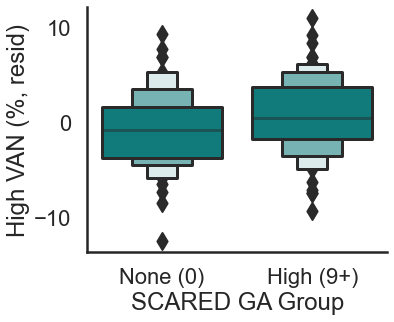

1.5027506458996467 0.13496456717281083


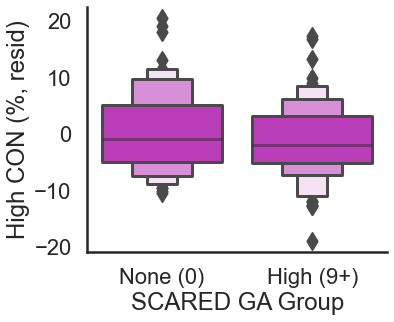

-1.7011538831126969 0.09094551288007537


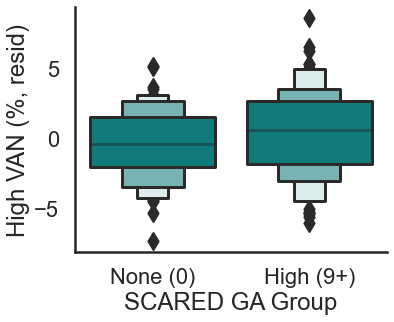

1.6642137111747648 0.09811645293977748


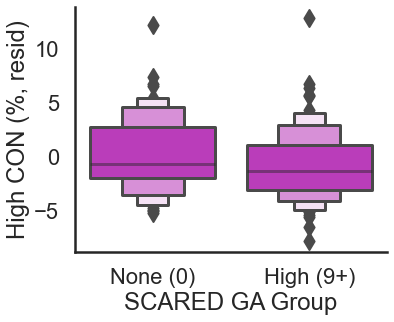

-4.032974666467041 8.666137690564492e-05


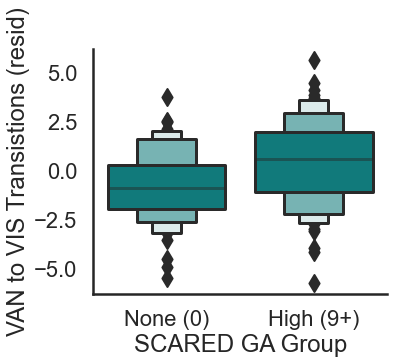

-3.391963208955645 0.0008833503519905182


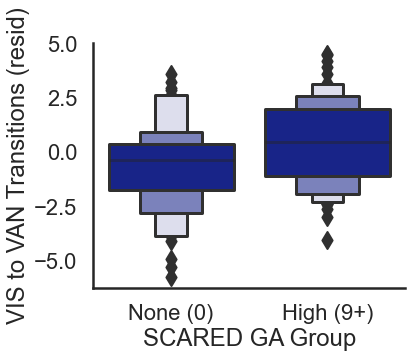

In [33]:
#full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
full_data['anx_group'] = np.nan
full_data.loc[full_data['SCARED_SR_GD']>=9, 'anx_group'] = 'High (9+)'
full_data.loc[full_data['SCARED_SR_GD']<1, 'anx_group'] = 'None (0)'

t, p = scp.ttest_ind(full_data.loc[full_data['anx_group']=='None (0)', 'resid_s3_pct'],
                     full_data.loc[full_data['anx_group']=='High (9+)', 'resid_s3_pct'])
print(t, p)
plt.figure(figsize=(6,5))
sns.boxenplot(x='anx_group', y='resid_s3_pct', data=full_data, color=state_palette[2])
plt.xlabel('SCARED GA Group')
plt.ylabel('High VAN (%, resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_GDgroupbypcent_s3.png'), dpi=300)
plt.show()
plt.close()

t, p = scp.ttest_ind(full_data.loc[full_data['anx_group']=='None (0)', 'resid_s2_pct'],
                     full_data.loc[full_data['anx_group']=='High (9+)', 'resid_s2_pct'])
print(t, p)
plt.figure(figsize=(6,5))
sns.boxenplot(x='anx_group', y='resid_s2_pct', data=full_data, color=state_palette[1])
plt.xlabel('SCARED GA Group')
plt.ylabel('High CON (%, resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_GDgroupbypcent_s2.png'), dpi=300)
plt.show()
plt.close()

t, p = scp.ttest_ind(full_data.loc[full_data['anx_group']=='None (0)', 'resid_neg_s3_pct'],
                     full_data.loc[full_data['anx_group']=='High (9+)', 'resid_neg_s3_pct'])
print(t, p)
plt.figure(figsize=(6,5))
sns.boxenplot(x='anx_group', y='resid_neg_s3_pct', data=full_data, color=state_palette[2])
plt.xlabel('SCARED GA Group')
plt.ylabel('High VAN (%, resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_neg_GDgroupbypcent_s3.png'), dpi=300)
plt.show()
plt.close()

t, p = scp.ttest_ind(full_data.loc[full_data['anx_group']=='None (0)', 'resid_neg_s2_pct'],
                     full_data.loc[full_data['anx_group']=='High (9+)', 'resid_neg_s2_pct'])
print(t, p)
plt.figure(figsize=(6,5))
sns.boxenplot(x='anx_group', y='resid_neg_s2_pct', data=full_data, color=state_palette[1])
plt.xlabel('SCARED GA Group')
plt.ylabel('High CON (%, resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_neg_GDgroupbypcent_s2.png'), dpi=300)
plt.show()
plt.close()

t, p = scp.ttest_ind(full_data.loc[full_data['anx_group']=='None (0)', 'resid_ntrans_s3_to_1_neg'],
                     full_data.loc[full_data['anx_group']=='High (9+)', 'resid_ntrans_s3_to_1_neg'])
print(t, p)
plt.figure(figsize=(6,5))
sns.boxenplot(x='anx_group', y='resid_ntrans_s3_to_1_neg', data=full_data, color=state_palette[2])
plt.xlabel('SCARED GA Group')
plt.ylabel('VAN to VIS Transistions (resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_neg_GDgroupbytrans_s3s1.png'), dpi=300)
plt.show()
plt.close()

t, p = scp.ttest_ind(full_data.loc[full_data['anx_group']=='None (0)', 'resid_ntrans_s1_to_3_neg'],
                     full_data.loc[full_data['anx_group']=='High (9+)', 'resid_ntrans_s1_to_3_neg'])
print(t, p)
plt.figure(figsize=(6,5))
sns.boxenplot(x='anx_group', y='resid_ntrans_s1_to_3_neg', data=full_data, color=state_palette[0])
plt.xlabel('SCARED GA Group')
plt.ylabel('VIS to VAN Transitions (resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_neg_GDgroupbytrans_s1s3.png'), dpi=300)
plt.show()
plt.close()

# final sample info

In [44]:
movie='DM'
subinfo = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
subinfo.describe()

,age,female,meanFD,righthanded,PPS_score,sample,SCARED_P_SC,SCARED_P_GD,SCARED_P_Total,SCARED_SR_SC,...,s3_to_2_neg,ntrans_s3_to_2_neg,s3_to_3_neg,ntrans_s3_to_3_neg,s1_to_2vs3_ratio_neg,s1_to_3vs2_ratio_neg,s2_to_1vs3_ratio_neg,s2_to_3vs1_ratio_neg,s3_to_1vs2_ratio_neg,s3_to_2vs1_ratio_neg
count,620.000000,620.000000,620.000000,620.000000,439.000000,620.000000,545.000000,545.000000,545.000000,432.000000,...,620.000000,620.000000,620.000000,620.000000,209.000000,244.000000,620.000000,620.000000,620.000000,617.000000
mean,10.433548,0.404839,0.359507,0.750000,9.739749,1.500000,4.245872,4.609174,14.245872,5.164352,...,0.039609,2.979032,0.890131,98.616129,3.193094,0.429218,14.553547,0.076109,0.049572,25.763358
std,2.807872,0.491257,0.184016,0.433362,4.254149,0.500404,3.642845,3.963935,10.470990,3.958993,...,0.021148,1.729123,0.027096,19.311938,6.131632,0.625393,5.238677,0.023042,0.023414,16.363181
min,5.061259,0.000000,0.054385,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.742424,39.000000,0.000000,0.000000,6.551587,0.019232,0.000000,6.706542
25%,8.165183,0.000000,0.209152,0.750000,6.000000,1.000000,1.000000,1.000000,6.000000,2.000000,...,0.025118,2.000000,0.875000,85.750000,0.686667,0.000000,10.903448,0.059519,0.032752,15.773810
50%,10.164328,0.000000,0.315161,1.000000,8.000000,1.500000,4.000000,4.000000,12.000000,5.000000,...,0.038462,3.000000,0.894309,98.000000,2.153846,0.242102,13.437473,0.074419,0.045154,22.048889
75%,12.845824,1.000000,0.485037,1.000000,13.000000,2.000000,7.000000,7.000000,20.000000,8.000000,...,0.051282,4.000000,0.909091,112.000000,3.928571,0.506837,16.801268,0.091714,0.063375,30.313253
max,15.974332,1.000000,0.908530,1.000000,20.000000,2.000000,14.000000,18.000000,52.000000,14.000000,...,0.122449,9.000000,0.942857,161.000000,75.727273,4.590164,51.996377,0.152635,0.149108,155.760000


In [41]:
print(subinfo.loc[subinfo['site']=='rubic',:].shape)
print(subinfo.loc[subinfo['site']=='cbic',:].shape)

(338, 8)
(282, 8)


In [42]:
print(subinfo.loc[subinfo['site']=='rubic',:].shape)
print(subinfo.loc[subinfo['site']=='cbic',:].shape)

(338, 8)
(282, 8)


In [45]:
print('PR and SR GD', scp.spearmanr(subinfo['SCARED_P_GD'],subinfo['SCARED_SR_GD'], nan_policy='omit'))
print('PR and SR SC', scp.spearmanr(subinfo['SCARED_P_SC'],subinfo['SCARED_SR_SC'], nan_policy='omit'))
print('PR and SR dep', scp.spearmanr(subinfo['MFQ_SR_Total'],subinfo['MFQ_P_Total'], nan_policy='omit'))
print('GD and dep', scp.spearmanr(subinfo['MFQ_SR_Total'],subinfo['SCARED_SR_GD'], nan_policy='omit'))
print('SC and dep', scp.spearmanr(subinfo['MFQ_SR_Total'],subinfo['SCARED_SR_SC'], nan_policy='omit'))

PR and SR GD SignificanceResult(statistic=0.2959898625983836, pvalue=5.078741726114962e-10)
PR and SR SC SignificanceResult(statistic=0.2882982561999518, pvalue=1.468540290410581e-09)
PR and SR dep SignificanceResult(statistic=0.26914915870054856, pvalue=1.2720958559402949e-08)
GD and dep SignificanceResult(statistic=0.5397472883901028, pvalue=4.968193778585129e-34)
SC and dep SignificanceResult(statistic=0.3625417994410557, pvalue=7.269759280585766e-15)


# Check for anxiety * age associations

## overall state info

In [2]:
pct = ['s1_percent', 's2_percent', 's3_percent']
trans = ['ntrans_s1_to_2_all', 'ntrans_s1_to_3_all','ntrans_s2_to_1_all',  
         'ntrans_s2_to_3_all','ntrans_s3_to_1_all', 'ntrans_s3_to_2_all']
odds = ['s1_to_1_all', 's1_to_2_all', 's1_to_3_all', 's2_to_1_all',
        's2_to_2_all', 's2_to_3_all', 's3_to_1_all', 's3_to_2_all',
        's3_to_3_all']
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg'] + pct + trans + odds
cs = ['SCARED_SR_GD', 'SCARED_SR_SC', 'SCARED_SR_Total', 'MFQ_SR_Total']
movie='DM'

results_df = pd.DataFrame()

i=0
for c in ['SCARED_SR_GD', 'SCARED_SR_SC']:
    start = i
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())
    
    for s in pct:
        m2 = smf.ols('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        ci=m2.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        
        results_df.loc[i, 'm2_IV_coeff'] = m2.params[c]
        results_df.loc[i, 'm2_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm2_IV_stat'] = m2.tvalues[c]
        results_df.loc[i, 'm2_IV_pval'] = m2.pvalues[c]
        results_df.loc[i, 'm2_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm2_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm2_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm2_age_pval'] = m2.pvalues['age']
        
        results = smf.ols('{0} ~ {1} + age + female + meanFD + age*{1}'.format(s, c), data=full_data).fit()

        res = anova_lm(m2, results)
        results_df.loc[i, 'm2vsm3_F'] = res.loc[1, 'F']
        results_df.loc[i, 'm2vsm3_pval'] = res.loc[1, 'Pr(>F)']
        
        ivar = 'age:{0}'.format(c)
        ci=results.conf_int()
        results_df.loc[i, 'm3_IV_coeff'] = results.params[c]
        results_df.loc[i, 'm3_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm3_IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'm3_IV_pval'] = results.pvalues[c]

        results_df.loc[i, 'm3_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm3_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm3_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm3_age_pval'] = m2.pvalues['age']
        
        results_df.loc[i, 'interact_coeff'] = results.params[ivar]
        results_df.loc[i, 'interact_ci'] = '[{0}, {1}]'.format(round(ci.loc[ivar,0],2),round(ci.loc[ivar,1],2))
        results_df.loc[i, 'interact_stat'] = results.tvalues[ivar]
        results_df.loc[i, 'interact_pval'] = results.pvalues[ivar]
        results_df.loc[i, 'm2vsm3_fdrp'] = np.nan
        i = i + 1
    rej, fdr_p = fdrcorrection(results_df['m2vsm3_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p
    
    start = i
    for s in trans:
        m2 = smf.ols('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        ci=m2.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        
        results_df.loc[i, 'm2_IV_coeff'] = m2.params[c]
        results_df.loc[i, 'm2_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm2_IV_stat'] = m2.tvalues[c]
        results_df.loc[i, 'm2_IV_pval'] = m2.pvalues[c]
        results_df.loc[i, 'm2_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm2_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm2_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm2_age_pval'] = m2.pvalues['age']
        
        results = smf.ols('{0} ~ {1} + age + female + meanFD + age*{1}'.format(s, c), data=full_data).fit()

        res = anova_lm(m2, results)
        results_df.loc[i, 'm2vsm3_F'] = res.loc[1, 'F']
        results_df.loc[i, 'm2vsm3_pval'] = res.loc[1, 'Pr(>F)']
        
        ivar = 'age:{0}'.format(c)
        ci=results.conf_int()
        results_df.loc[i, 'm3_IV_coeff'] = results.params[c]
        results_df.loc[i, 'm3_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm3_IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'm3_IV_pval'] = results.pvalues[c]

        results_df.loc[i, 'm3_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm3_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm3_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm3_age_pval'] = m2.pvalues['age']
        
        results_df.loc[i, 'interact_coeff'] = results.params[ivar]
        results_df.loc[i, 'interact_ci'] = '[{0}, {1}]'.format(round(ci.loc[ivar,0],2),round(ci.loc[ivar,1],2))
        results_df.loc[i, 'interact_stat'] = results.tvalues[ivar]
        results_df.loc[i, 'interact_pval'] = results.pvalues[ivar]
        results_df.loc[i, 'm2vsm3_fdrp'] = np.nan
        i = i + 1
    _, fdr_p = fdrcorrection(results_df['interact_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p

    start = i
    for s in odds:
        m2 = smf.ols('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        ci=m2.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        
        results_df.loc[i, 'm2_IV_coeff'] = m2.params[c]
        results_df.loc[i, 'm2_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm2_IV_stat'] = m2.tvalues[c]
        results_df.loc[i, 'm2_IV_pval'] = m2.pvalues[c]
        results_df.loc[i, 'm2_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm2_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm2_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm2_age_pval'] = m2.pvalues['age']
        
        results = smf.ols('{0} ~ {1} + age + female + meanFD + age*{1}'.format(s, c), data=full_data).fit()

        res = anova_lm(m2, results)
        results_df.loc[i, 'm2vsm3_F'] = res.loc[1, 'F']
        results_df.loc[i, 'm2vsm3_pval'] = res.loc[1, 'Pr(>F)']
        
        ivar = 'age:{0}'.format(c)
        ci=results.conf_int()
        results_df.loc[i, 'm3_IV_coeff'] = results.params[c]
        results_df.loc[i, 'm3_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm3_IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'm3_IV_pval'] = results.pvalues[c]

        results_df.loc[i, 'm3_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm3_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm3_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm3_age_pval'] = m2.pvalues['age']
        
        results_df.loc[i, 'interact_coeff'] = results.params[ivar]
        results_df.loc[i, 'interact_ci'] = '[{0}, {1}]'.format(round(ci.loc[ivar,0],2),round(ci.loc[ivar,1],2))
        results_df.loc[i, 'interact_stat'] = results.tvalues[ivar]
        results_df.loc[i, 'interact_pval'] = results.pvalues[ivar]
        results_df.loc[i, 'm2vsm3_fdrp'] = np.nan
        i = i + 1
    _, fdr_p = fdrcorrection(results_df['interact_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p
results_df.to_csv(os.path.join(out_folder, 'movieDM_full_GDbyAge_analysis_results.csv'))
results_df.round(3)

,movie,DV,IV,m2_IV_coeff,m2_IV_ci,m2_IV_stat,m2_IV_pval,m2_age_coeff,m2_age_ci,m2_age_stat,...,m3_IV_pval,m3_age_coeff,m3_age_ci,m3_age_stat,m3_age_pval,interact_coeff,interact_ci,interact_stat,interact_pval,m2vsm3_fdrp
0,DM,s1_percent,SCARED_SR_GD,0.048,"[-0.05, 0.14]",0.977,0.329,-0.036,"[-0.16, 0.08]",-0.588,...,0.875,-0.036,"[-0.17, 0.07]",-0.588,0.557,0.132,"[0.01, 0.25]",2.142,0.033,0.098
1,DM,s2_percent,SCARED_SR_GD,-0.094,"[-0.19, -0.0]",-2.012,0.045,0.235,"[0.12, 0.35]",4.048,...,0.216,0.235,"[0.13, 0.35]",4.048,0.000,-0.066,"[-0.18, 0.05]",-1.116,0.265,0.265
2,DM,s3_percent,SCARED_SR_GD,0.124,"[0.03, 0.22]",2.627,0.009,-0.108,"[-0.22, 0.01]",-1.823,...,0.002,-0.108,"[-0.22, 0.02]",-1.823,0.069,-0.097,"[-0.21, 0.02]",-1.624,0.105,0.158
3,DM,ntrans_s1_to_2_all,SCARED_SR_GD,-0.028,"[-0.12, 0.06]",-0.597,0.551,0.137,"[0.02, 0.25]",2.343,...,0.998,0.137,"[0.03, 0.26]",2.343,0.020,-0.066,"[-0.18, 0.05]",-1.108,0.269,0.613
4,DM,ntrans_s1_to_3_all,SCARED_SR_GD,0.056,"[-0.04, 0.15]",1.189,0.235,-0.039,"[-0.15, 0.08]",-0.656,...,0.530,-0.039,"[-0.16, 0.07]",-0.656,0.512,0.052,"[-0.07, 0.17]",0.873,0.383,0.613
5,DM,ntrans_s2_to_1_all,SCARED_SR_GD,-0.024,"[-0.12, 0.07]",-0.491,0.624,0.113,"[-0.01, 0.23]",1.837,...,0.723,0.113,"[-0.01, 0.23]",1.837,0.067,-0.010,"[-0.13, 0.11]",-0.161,0.872,0.872
6,DM,ntrans_s2_to_3_all,SCARED_SR_GD,-0.053,"[-0.15, 0.04]",-1.097,0.273,0.135,"[0.02, 0.25]",2.226,...,0.690,0.135,"[0.02, 0.26]",2.226,0.027,-0.073,"[-0.19, 0.05]",-1.188,0.235,0.613
7,DM,ntrans_s3_to_1_all,SCARED_SR_GD,0.022,"[-0.07, 0.12]",0.453,0.651,0.002,"[-0.12, 0.12]",0.034,...,0.429,0.002,"[-0.11, 0.12]",0.034,0.973,-0.050,"[-0.17, 0.07]",-0.827,0.409,0.613
8,DM,ntrans_s3_to_2_all,SCARED_SR_GD,-0.013,"[-0.11, 0.08]",-0.268,0.789,0.199,"[0.08, 0.32]",3.279,...,0.956,0.199,"[0.08, 0.32]",3.279,0.001,-0.023,"[-0.14, 0.1]",-0.380,0.704,0.845
9,DM,s1_to_1_all,SCARED_SR_GD,0.027,"[-0.07, 0.12]",0.545,0.586,0.047,"[-0.07, 0.17]",0.769,...,0.770,0.047,"[-0.08, 0.16]",0.769,0.443,0.101,"[-0.02, 0.22]",1.622,0.105,0.316


In [6]:
results_df.loc[(results_df['IV']=='SCARED_SR_GD') & (results_df['m2vsm3_pval']<0.05) & (results_df['interact_pval']<0.05),:]

,movie,DV,IV,m2_IV_coeff,m2_IV_stat,m2_IV_pval,m2_IV_ci,m2vsm3_F,m2vsm3_pval,m3_IV_coeff,m3_IV_stat,m3_IV_pval,m3_IV_ci,interact_coeff,interact_stat,interact_pval,interact_ci,interact_FDRp
0,DM,s1_percent,SCARED_SR_GD,0.047824,0.977056,0.329095,"[-0.05, 0.14]",4.588882,0.032746,-0.008713,-0.157196,0.875165,"[-0.12, 0.1]",0.132048,2.142168,0.032746,"[0.01, 0.25]",0.098239
15,DM,s3_to_1_all,SCARED_SR_GD,-0.007390,-0.150374,0.880541,"[-0.1, 0.09]",6.351656,0.012092,0.059258,1.066951,0.286598,"[-0.05, 0.17]",-0.155663,-2.520249,0.012092,"[-0.28, -0.03]",0.108825


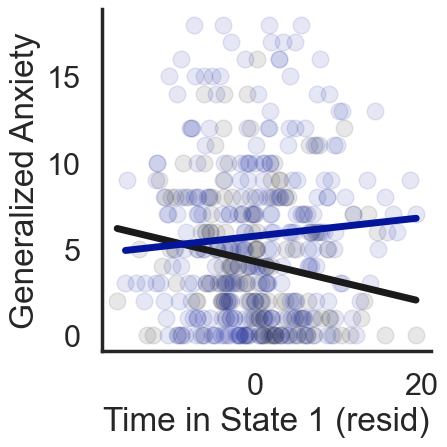

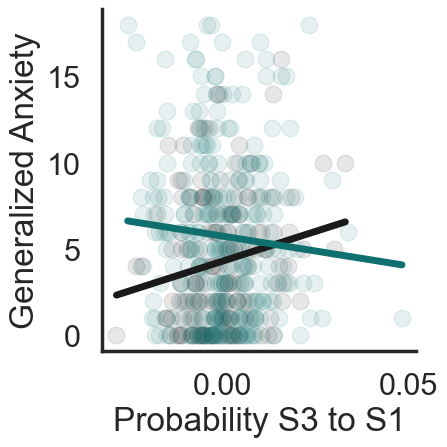

In [9]:
sns.set(context='poster', style='white')
# residualized brain state measures and plot

IV = 'SCARED_SR_GD'
DV = 's1_percent'

full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
full_data.loc[:,'age_group'] = 'younger'
full_data.loc[full_data['age']>np.percentile(full_data['age'], 50),'age_group'] = 'older'
res = smf.glm('{0} ~ age + female + meanFD + {1}'.format(DV, IV), data=full_data).fit()
t = pd.DataFrame(res.resid_response, index = res.resid_response.index, columns = ['resid_{0}'.format(DV)])
full_data = full_data.merge(t, how='left', left_index=True, right_index=True) 

sns.lmplot(x='resid_{0}'.format(DV), y=IV, data=full_data, ci=None, hue='age_group', 
           palette=['k', state_palette[0]], hue_order=['younger','older'], legend=None,
           line_kws={'lw':5},
           scatter_kws={'alpha':0.1})
plt.ylabel('Generalized Anxiety')
plt.xlabel('Time in State 1 (resid)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_GD-age-interact_pred_{0}.png'.format(DV)), dpi=300)
plt.show()
plt.close()



IV = 'SCARED_SR_GD'
DV = 's3_to_1_all'

full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
full_data.loc[:,'age_group'] = 'younger'
full_data.loc[full_data['age']>np.percentile(full_data['age'], 50),'age_group'] = 'older'
res = smf.glm('{0} ~ age + female + meanFD + {1}'.format(DV, IV), data=full_data).fit()
t = pd.DataFrame(res.resid_response, index = res.resid_response.index, columns = ['resid_{0}'.format(DV)])
full_data = full_data.merge(t, how='left', left_index=True, right_index=True) 

sns.lmplot(x='resid_{0}'.format(DV), y=IV, data=full_data, ci=None, hue='age_group', 
           palette=['k', state_palette[2]], hue_order=['younger','older'], legend=None,
           line_kws={'lw':5},
           scatter_kws={'alpha':0.1})
plt.ylabel('Generalized Anxiety')
plt.xlabel('Probability S3 to S1')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'movieDM_scatter_GD-age-interact_pred_{0}.png'.format(DV)), dpi=300)
plt.show()
plt.close()


## during negative emotion processing

In [3]:
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg', 'neg_s1_pct',
       'nonneg_s1_pct', 'neg_s1_prob', 'nonneg_s1_prob', 'neg_s2_pct',
       'nonneg_s2_pct', 'neg_s2_prob', 'nonneg_s2_prob', 'neg_s3_pct',
       'nonneg_s3_pct', 'neg_s3_prob', 'nonneg_s3_prob']

cs = ['SCARED_P_SC', 'SCARED_P_GD', 'SCARED_P_Total',
       'SCARED_SR_SC', 'SCARED_SR_GD', 'SCARED_SR_Total']

vois_neg_pct = ['neg_s1_pct','neg_s2_pct', 'neg_s3_pct']

vois_nonneg_pct = ['nonneg_s1_pct', 'nonneg_s2_pct', 'nonneg_s3_pct']

vois_txodds = ['s1_to_1_neg', 's1_to_2_neg', 's1_to_3_neg',
               's2_to_1_neg', 's2_to_2_neg', 's2_to_3_neg', 
               's3_to_1_neg', 's3_to_2_neg', 's3_to_3_neg']

vois_trans = ['ntrans_s1_to_2_neg','ntrans_s1_to_3_neg','ntrans_s2_to_1_neg',
              'ntrans_s2_to_3_neg','ntrans_s3_to_1_neg','ntrans_s3_to_2_neg']


movie='DM'
results_df = pd.DataFrame()
i=0

full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())

i=0
for c in ['SCARED_SR_GD', 'SCARED_SR_SC']:
    start = i
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())
    
    for s in vois_neg_pct:
        m2 = smf.ols('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        ci=m2.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        
        results_df.loc[i, 'm2_IV_coeff'] = m2.params[c]
        results_df.loc[i, 'm2_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm2_IV_stat'] = m2.tvalues[c]
        results_df.loc[i, 'm2_IV_pval'] = m2.pvalues[c]
        results_df.loc[i, 'm2_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm2_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm2_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm2_age_pval'] = m2.pvalues['age']
        
        results = smf.ols('{0} ~ {1} + age + female + meanFD + age*{1}'.format(s, c), data=full_data).fit()

        res = anova_lm(m2, results)
        results_df.loc[i, 'm2vsm3_F'] = res.loc[1, 'F']
        results_df.loc[i, 'm2vsm3_pval'] = res.loc[1, 'Pr(>F)']
        
        ivar = 'age:{0}'.format(c)
        ci=results.conf_int()
        results_df.loc[i, 'm3_IV_coeff'] = results.params[c]
        results_df.loc[i, 'm3_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm3_IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'm3_IV_pval'] = results.pvalues[c]

        results_df.loc[i, 'm3_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm3_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm3_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm3_age_pval'] = m2.pvalues['age']
        
        results_df.loc[i, 'interact_coeff'] = results.params[ivar]
        results_df.loc[i, 'interact_ci'] = '[{0}, {1}]'.format(round(ci.loc[ivar,0],2),round(ci.loc[ivar,1],2))
        results_df.loc[i, 'interact_stat'] = results.tvalues[ivar]
        results_df.loc[i, 'interact_pval'] = results.pvalues[ivar]
        results_df.loc[i, 'm2vsm3_fdrp'] = np.nan
        i = i + 1
    rej, fdr_p = fdrcorrection(results_df['interact_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p
    
    start = i
    for s in vois_nonneg_pct:
        m2 = smf.ols('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        ci=m2.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        
        results_df.loc[i, 'm2_IV_coeff'] = m2.params[c]
        results_df.loc[i, 'm2_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm2_IV_stat'] = m2.tvalues[c]
        results_df.loc[i, 'm2_IV_pval'] = m2.pvalues[c]
        results_df.loc[i, 'm2_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm2_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm2_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm2_age_pval'] = m2.pvalues['age']
        
        results = smf.ols('{0} ~ {1} + age + female + meanFD + age*{1}'.format(s, c), data=full_data).fit()

        res = anova_lm(m2, results)
        results_df.loc[i, 'm2vsm3_F'] = res.loc[1, 'F']
        results_df.loc[i, 'm2vsm3_pval'] = res.loc[1, 'Pr(>F)']
        
        ivar = 'age:{0}'.format(c)
        ci=results.conf_int()
        results_df.loc[i, 'm3_IV_coeff'] = results.params[c]
        results_df.loc[i, 'm3_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm3_IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'm3_IV_pval'] = results.pvalues[c]

        results_df.loc[i, 'm3_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm3_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm3_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm3_age_pval'] = m2.pvalues['age']
        
        results_df.loc[i, 'interact_coeff'] = results.params[ivar]
        results_df.loc[i, 'interact_ci'] = '[{0}, {1}]'.format(round(ci.loc[ivar,0],2),round(ci.loc[ivar,1],2))
        results_df.loc[i, 'interact_stat'] = results.tvalues[ivar]
        results_df.loc[i, 'interact_pval'] = results.pvalues[ivar]
        results_df.loc[i, 'm2vsm3_fdrp'] = np.nan
        i = i + 1
    _, fdr_p = fdrcorrection(results_df['interact_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p

    start = i
    for s in vois_txodds:
        m2 = smf.ols('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        ci=m2.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        
        results_df.loc[i, 'm2_IV_coeff'] = m2.params[c]
        results_df.loc[i, 'm2_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm2_IV_stat'] = m2.tvalues[c]
        results_df.loc[i, 'm2_IV_pval'] = m2.pvalues[c]
        results_df.loc[i, 'm2_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm2_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm2_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm2_age_pval'] = m2.pvalues['age']
        
        results = smf.ols('{0} ~ {1} + age + female + meanFD + age*{1}'.format(s, c), data=full_data).fit()

        res = anova_lm(m2, results)
        results_df.loc[i, 'm2vsm3_F'] = res.loc[1, 'F']
        results_df.loc[i, 'm2vsm3_pval'] = res.loc[1, 'Pr(>F)']
        
        ivar = 'age:{0}'.format(c)
        ci=results.conf_int()
        results_df.loc[i, 'm3_IV_coeff'] = results.params[c]
        results_df.loc[i, 'm3_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm3_IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'm3_IV_pval'] = results.pvalues[c]

        results_df.loc[i, 'm3_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm3_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm3_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm3_age_pval'] = m2.pvalues['age']
        
        results_df.loc[i, 'interact_coeff'] = results.params[ivar]
        results_df.loc[i, 'interact_ci'] = '[{0}, {1}]'.format(round(ci.loc[ivar,0],2),round(ci.loc[ivar,1],2))
        results_df.loc[i, 'interact_stat'] = results.tvalues[ivar]
        results_df.loc[i, 'interact_pval'] = results.pvalues[ivar]
        results_df.loc[i, 'm2vsm3_fdrp'] = np.nan
        i = i + 1
    _, fdr_p = fdrcorrection(results_df['interact_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p

    start = i
    for s in vois_trans:
        m2 = smf.ols('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
        ci=m2.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'IV'] = c
        
        results_df.loc[i, 'm2_IV_coeff'] = m2.params[c]
        results_df.loc[i, 'm2_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm2_IV_stat'] = m2.tvalues[c]
        results_df.loc[i, 'm2_IV_pval'] = m2.pvalues[c]
        results_df.loc[i, 'm2_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm2_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm2_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm2_age_pval'] = m2.pvalues['age']
        
        results = smf.ols('{0} ~ {1} + age + female + meanFD + age*{1}'.format(s, c), data=full_data).fit()

        res = anova_lm(m2, results)
        results_df.loc[i, 'm2vsm3_F'] = res.loc[1, 'F']
        results_df.loc[i, 'm2vsm3_pval'] = res.loc[1, 'Pr(>F)']
        
        ivar = 'age:{0}'.format(c)
        ci=results.conf_int()
        results_df.loc[i, 'm3_IV_coeff'] = results.params[c]
        results_df.loc[i, 'm3_IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
        results_df.loc[i, 'm3_IV_stat'] = results.tvalues[c]
        results_df.loc[i, 'm3_IV_pval'] = results.pvalues[c]

        results_df.loc[i, 'm3_age_coeff'] = m2.params['age']
        results_df.loc[i, 'm3_age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'm3_age_stat'] = m2.tvalues['age']
        results_df.loc[i, 'm3_age_pval'] = m2.pvalues['age']
        
        results_df.loc[i, 'interact_coeff'] = results.params[ivar]
        results_df.loc[i, 'interact_ci'] = '[{0}, {1}]'.format(round(ci.loc[ivar,0],2),round(ci.loc[ivar,1],2))
        results_df.loc[i, 'interact_stat'] = results.tvalues[ivar]
        results_df.loc[i, 'interact_pval'] = results.pvalues[ivar]
        results_df.loc[i, 'm2vsm3_fdrp'] = np.nan
        i = i + 1
    _, fdr_p = fdrcorrection(results_df['interact_pval'][start:i])
    results_df.iloc[start:i, -1] = fdr_p

results_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_GDbyAge_sanalysis_results.csv'.format(movie)))
results_df.round(3)

,movie,DV,IV,m2_IV_coeff,m2_IV_ci,m2_IV_stat,m2_IV_pval,m2_age_coeff,m2_age_ci,m2_age_stat,...,m3_IV_pval,m3_age_coeff,m3_age_ci,m3_age_stat,m3_age_pval,interact_coeff,interact_ci,interact_stat,interact_pval,m2vsm3_fdrp
0,DM,neg_s1_pct,SCARED_SR_GD,0.073,"[-0.02, 0.17]",1.499,0.134,0.022,"[-0.1, 0.14]",0.353,...,0.552,0.022,"[-0.11, 0.13]",0.353,0.724,0.094,"[-0.03, 0.22]",1.523,0.129,0.386
1,DM,neg_s2_pct,SCARED_SR_GD,-0.113,"[-0.21, -0.02]",-2.369,0.018,0.130,"[0.01, 0.25]",2.175,...,0.084,0.130,"[0.02, 0.25]",2.175,0.030,-0.044,"[-0.16, 0.07]",-0.734,0.463,0.463
2,DM,neg_s3_pct,SCARED_SR_GD,0.104,"[0.01, 0.2]",2.148,0.032,-0.041,"[-0.16, 0.08]",-0.684,...,0.022,-0.041,"[-0.16, 0.08]",-0.684,0.495,-0.052,"[-0.17, 0.07]",-0.856,0.393,0.463
3,DM,nonneg_s1_pct,SCARED_SR_GD,0.016,"[-0.08, 0.11]",0.327,0.744,-0.076,"[-0.2, 0.04]",-1.242,...,0.516,-0.076,"[-0.21, 0.03]",-1.242,0.215,0.122,"[0.0, 0.24]",1.971,0.049,0.148
4,DM,nonneg_s2_pct,SCARED_SR_GD,-0.054,"[-0.15, 0.04]",-1.138,0.256,0.262,"[0.15, 0.38]",4.454,...,0.643,0.262,"[0.15, 0.38]",4.454,0.000,-0.067,"[-0.18, 0.05]",-1.130,0.259,0.259
5,DM,nonneg_s3_pct,SCARED_SR_GD,0.074,"[-0.02, 0.17]",1.478,0.140,-0.106,"[-0.23, 0.02]",-1.693,...,0.056,-0.106,"[-0.22, 0.02]",-1.693,0.091,-0.082,"[-0.21, 0.04]",-1.291,0.197,0.259
6,DM,s1_to_1_neg,SCARED_SR_GD,-0.000,"[-0.0, 0.0]",-0.146,0.884,0.004,"[-0.0, 0.01]",1.757,...,0.895,0.004,"[-0.0, 0.01]",1.757,0.080,0.000,"[-0.0, 0.0]",0.008,0.994,0.994
7,DM,s1_to_2_neg,SCARED_SR_GD,0.002,"[-0.0, 0.0]",1.174,0.241,0.000,"[-0.0, 0.0]",0.154,...,0.563,0.000,"[-0.0, 0.0]",0.154,0.878,0.002,"[-0.0, 0.01]",0.953,0.341,0.994
8,DM,s1_to_3_neg,SCARED_SR_GD,0.002,"[0.0, 0.0]",1.967,0.050,-0.002,"[-0.0, 0.0]",-1.346,...,0.636,-0.002,"[-0.0, 0.0]",-1.346,0.179,0.003,"[0.0, 0.01]",2.662,0.008,0.073
9,DM,s2_to_1_neg,SCARED_SR_GD,-0.001,"[-0.0, 0.0]",-1.101,0.272,0.001,"[-0.0, 0.0]",0.602,...,0.349,0.001,"[-0.0, 0.0]",0.602,0.548,-0.000,"[-0.0, 0.0]",-0.061,0.952,0.994


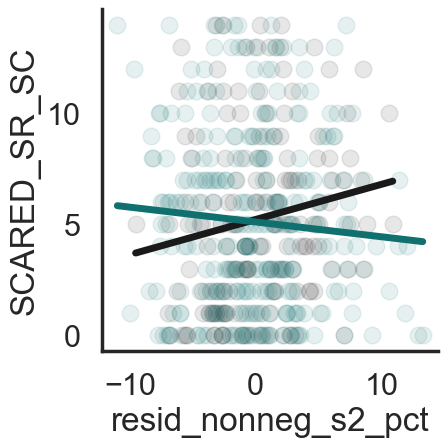

In [40]:
sns.set(context='poster', style='white')
# residualized brain state measures and plot
sig = results_df.loc[results_df['interact_FDRp']<0.05,:]
for i in sig.index:
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,'age_group'] = 'younger'
    full_data.loc[full_data['age']>np.percentile(full_data['age'], 50),'age_group'] = 'older'
    res = smf.glm('{0} ~ age + female + meanFD + {1}'.format(sig.loc[i, 'DV'],sig.loc[i, 'IV']), data=full_data).fit()
    t = pd.DataFrame(res.resid_response, index = res.resid_response.index, columns = ['resid_{0}'.format(sig.loc[i, 'DV'])])
    full_data = full_data.merge(t, how='left', left_index=True, right_index=True) 
    
    sns.lmplot(x='resid_{0}'.format(sig.loc[i, 'DV']), y=sig.loc[i, 'IV'], data=full_data, ci=None, hue='age_group', 
               palette=['k', state_palette[2]], hue_order=['younger','older'], legend=None,
               line_kws={'lw':5},
               scatter_kws={'alpha':0.1})
    #plt.ylabel('Generalized Anxiety')
    #plt.xlabel('Time in High VAN (resid)')
    sns.despine()
    plt.tight_layout()
    plt.savefig(os.path.join(out_folder, 'movieDM_scatter_{0}-age-interact_pred_{1}.png'.format(sig.loc[i, 'DV'],sig.loc[i, 'DV'])), dpi=300)
    plt.show()
    plt.close()